首先我们需要加载数据, torchvision.dataset 为我们提供了ImgaeFolder这样的快捷函数来处理数据集  
emmm 这个数据集里全是女孩子啊，如果女孩子和男孩子数量差不多就更好了  

len of dataset: 63565
len of subset: 10594


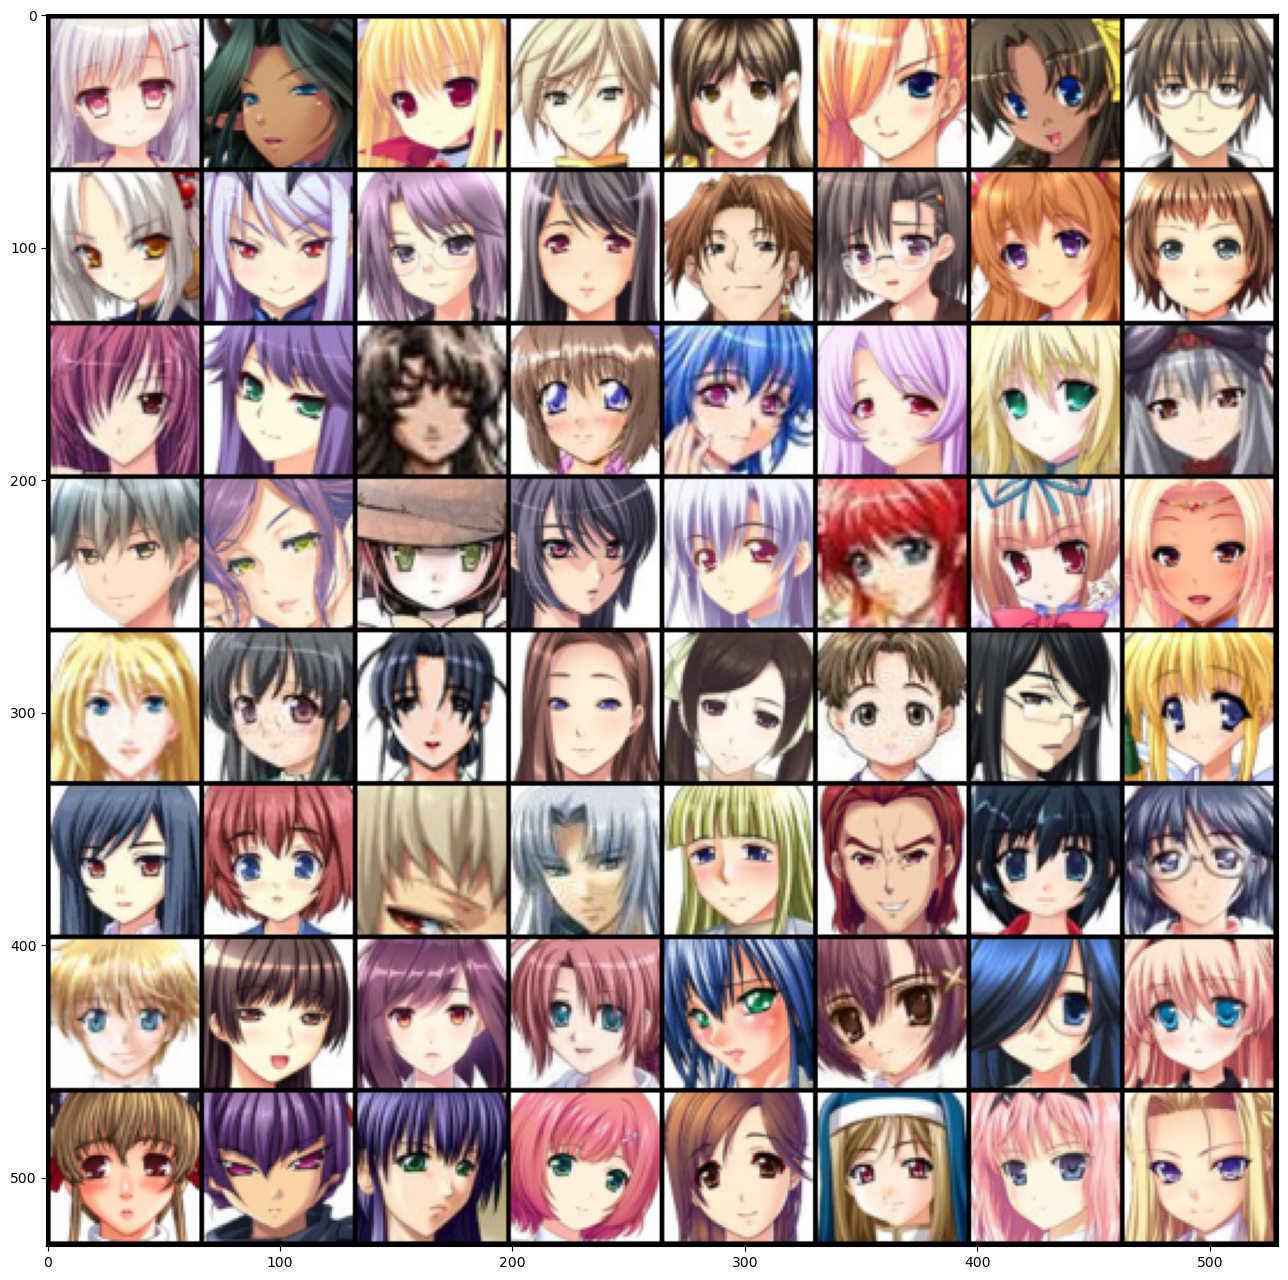

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as tdata
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

image_size = 64
batch_size = 256

# Normalize 接受两个向量，分别作为标准化的均值和方差 采用公式 x'=(x-mean)/std 我们的目标是将在[0,1]的像素值标准化到[-1,1]的空间
dataset = dset.ImageFolder(root='./data', transform=transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.CenterCrop(image_size), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))

# 整个数据集由6万多张图片，我们只要1/6就好了
len_of_dataset = len(dataset)
print(f'len of dataset: {len_of_dataset}')
len_of_subset = len_of_dataset // 6
print(f'len of subset: {len_of_subset}')
indices = list(range(len_of_dataset))
np.random.shuffle(indices)
indices = indices[:len_of_subset]
subset = tdata.Subset(dataset=dataset, indices=indices)


dataloader = tdata.DataLoader(dataset=subset, batch_size=batch_size, num_workers=0, shuffle=True)

device = torch.device('mps')

# show data images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,16))
# 这里我们需要将通道从(C,H,W)调整为(H,W,C)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

接下来我们要设计noise_scheduler，它的作用是向图片根据输入的强度增加一定的noise  
最初设计时，我们是想象noise_scheduler随着时间t增加，不断向上一个时间步的图片增加新的noise，但是这种串行计算太耗时间，因此我们改为直接根据一个强度系数决定要向图片中添加多少noise  
接着我们可以进一步，用1减去强度系数，最后按步数相乘，得到的数值意味着“我们希望保留多少原本图片的信息”  
请看图片：  
![Screenshot 2024-07-21 at 10.54.12.png](https://files.lsmcloud.top/blog452d9259845f5378ac72bee368ebd522.png)
对于强度系数的安排，我们直接使用最简单的线性定步长增长(也就是说每步增加噪声的步子以恒定的速度，越迈越大)，一些研究会聚焦于如何更改noise_sheduler的增长方式改进训练效果  
上图这个公式的直观含义就是我们以$x_0$为输入，从以$\sqrt{\bar{a}}x_0$为中心，$(1-\bar{a})I$为方差的高斯分步中采样（我们只需要调用troch.random()，采样到的系数肯定就是符合高斯分布的啦~）  

In [2]:
import torch.nn.functional as F 

def get_linear_beta(t):
    """
    根据步数t得到线性增长的噪声系数
    """
    return torch.linspace(0.0001, 0.02, t)

# 其实我还没看懂这个函数，下面用的时候t其实就是个1*1的单值列表，看起来gather函数就是取出来了t步时的alpha，这个batch_size我感觉在语境下也只能是1啊，为什么会搞地这么麻烦呢
def align_coe(align_target, t, shape):
    """
    我们前面得到的系数是标量，我们需要填充为与x0相同维度的向量才能操作
    这个函数提取出第t步的alpha并且等值填充到与图像相同的大小
    """
    batch_size = t.shape[0] # 图片是按照批次传入的，我们一次forward操作是要处理很多图片的
    # Debugged: 当x0的数量不够时，相应的t也要被裁剪
    # t = t[:shape[0]]
    # 知识点：torch.gathers(dim,input,index) 首先要求index与input维度是对其的（每个维度具体的元素数无所谓），然后将index元素中的idx of idx（index中这个元素在index中的位置）的第dim维的值，替换为这个元素具体的值（真的很难表达清楚啊，虽然这个设计挺妙的，但是逻辑真的反人类啊！）
    tar_alpha = torch.gather(align_target, -1, t.cpu()) # 沿着最后一个维度（这alphas感觉也就一个维度啊...）选择第t作为索引的元素，所以这里t就是起了个index的作用
    # Debugged: 之前这里直接用的batch_size，但是当数据集不能直接被batch_size除尽时，x0的shape[0]是不到256的, edit: 我直接产生t的时候就把他们对齐了
    return tar_alpha.reshape((batch_size, *((1,) * (len(shape) - 1)))).to(device) # 这步真的没看懂，我猜想是和image的维度对齐，但是啊为啥是(batch_size, 1, 1)啊，看起来可能是通道 c这个维度被舍弃了，可能反正每个通道都是相同的乘法操作？但是下面直接和x0做乘法操作，形状不会不匹配吗...

def diffusion_forward(x0, t):
    """
    这个函数根据t，取出对应的alphas，为图像添加噪声
    """
    noise = torch.randn_like(x0)
    sqrt_alpha_cumprod_t = align_coe(sqrt_alphas_cumprod, t, x0.shape)
    sqrt_one_minus_alpha_cumprod_t = align_coe(sqrt_one_minus_alphas_cumprod, t, x0.shape)
    
    xt = sqrt_alpha_cumprod_t.to(device) * x0.to(device) + sqrt_one_minus_alpha_cumprod_t.to(device) * noise.to(device)
    return xt.to(device), noise.to(device)

T = 300
betas = get_linear_beta(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, 0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
# pytorch 切片操作：sequence[start:stop:step]
print()


嗯我们来试一试对数据集里的图片添加noise，测试下encoding环节

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0127285..1.0201613].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4316394..1.3947251].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9829915..2.08077].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3953614..2.4598966].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7819872..2.6213896].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.78129..3.0071254].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5317032..3

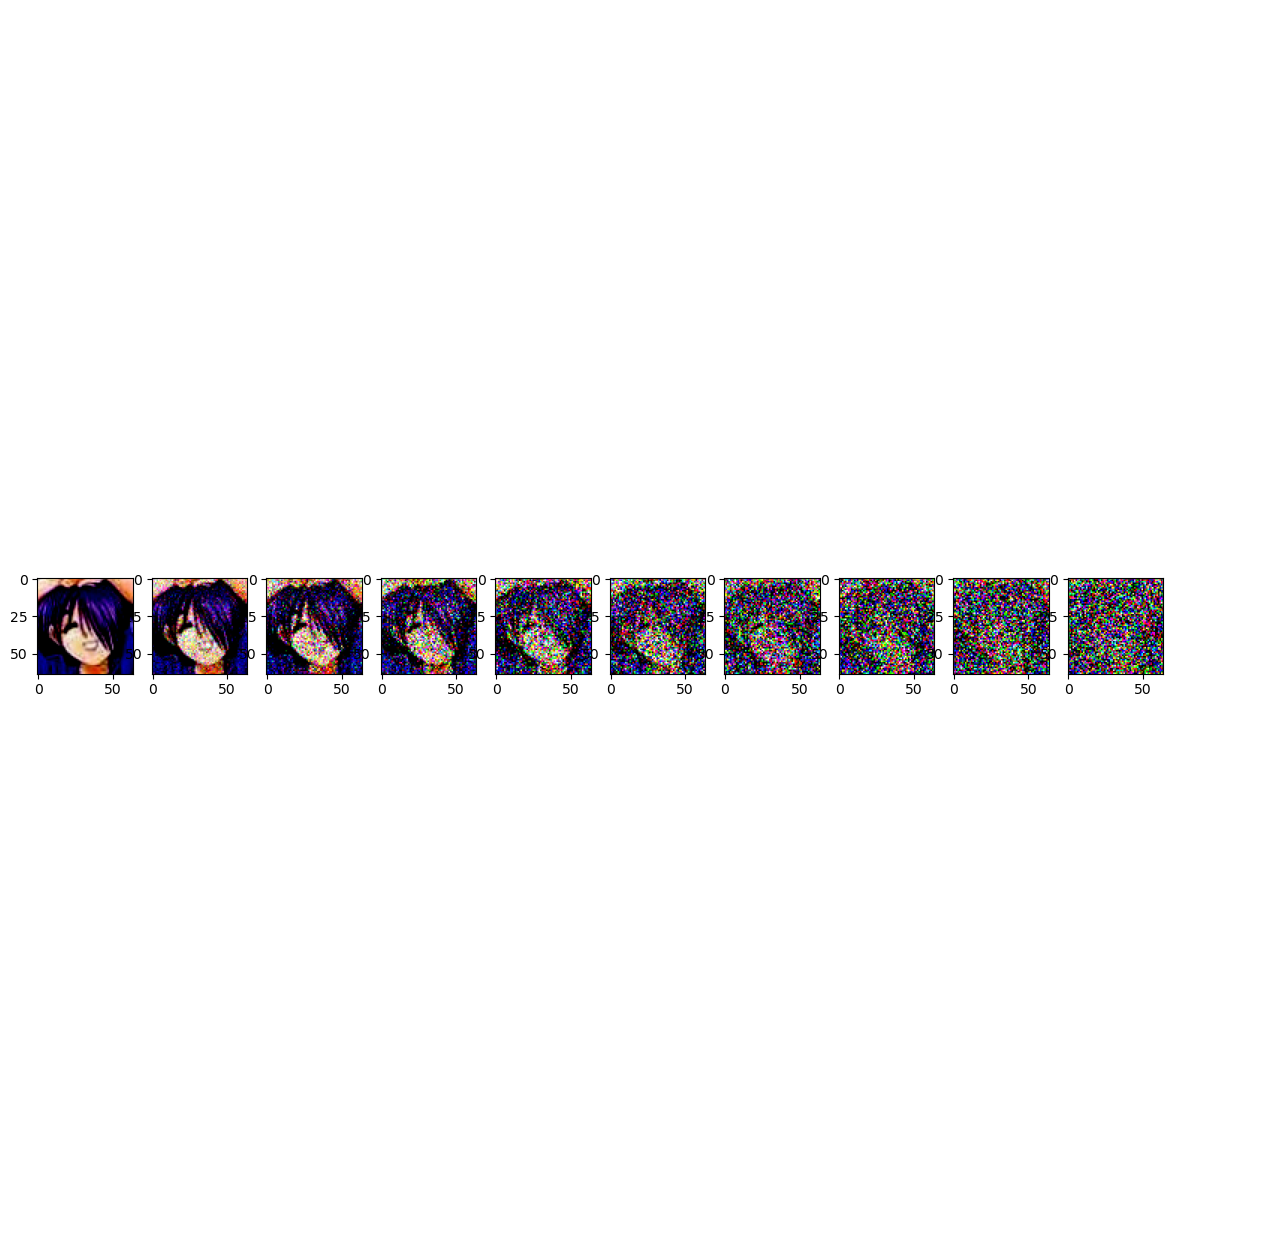

In [3]:
image = next(iter(dataset))[0]

show_count = 10
plt.figure(figsize=(16, 16))
plt.axis(False)
plt.subplot()
for epoch in range(0, T, int(T / show_count)):
    noised_img, noise = diffusion_forward(
        image[None, :], torch.Tensor([epoch]).type(torch.int64)
    )
    plt.subplot(1, show_count + 1, int(epoch / (T / show_count) + 1))
    plt.imshow(np.transpose(noised_img[0].cpu(), (1, 2, 0)))

现在我们要写noise_predictor了
diffusion_model使用的noise_predictor是U-Net架构，我个人感觉它的典型特征是单个通道的数据越砍越小，但是通道数越来越多，这种思路我感觉和multi-head transformer有点像，但是我还没有找到很信服的解释，特别是带有数学的解释（或者我没有看懂 啊啊啊啊这种一知半解的感觉好不爽！

In [4]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, up=False):
        super().__init__()

        self.t_embed_mlp = nn.Linear(emb_dim, out_ch)
        self.relu = nn.PReLU(init=0.3) # 相对于一般的diffusion model，我们的参数量太小了，直接用relu可能会浪费一些神经元
        # 这里也有点奇怪啊，你明明已经过了一层卷积了啊，为啥不把两件事情交给一个层做，非要重新过一层卷积，emmm难道区别在conv2d和transpose2d里吗？
        self.bnorm1 = nn.BatchNorm2d(out_ch) # TODO 这个也还要看看啊
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            # 关于transposed convolution layer可以看这个 https://d2l.ai/chapter_computer-vision/transposed-conv.html 
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            # out_size = (in + 2 - 3) / 1 +1 = in 
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            # out_size = (in + 2 -4) / 2 + 1 = in / 2
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1) # 再来一层conv进一步扩大感受野
    
    def forward(self, x, t_embd):
        # TODO 过了好多层relu啊...为啥
        t_embd = self.relu(self.t_embed_mlp(t_embd))
        # 为什么先relu再bnorm？ bnorm 和 relu 以及 dropout谁先谁后已经有长久的争论，我想需要数学工作者来回答 https://blog.paperspace.com/busting-the-myths-about-batch-normalization/
        x = self.relu(self.bnorm1(self.conv1(x)))
        # TODO 这个bnorm应用的时机我觉得也很怪啊，我还是要看看官方的实现才行
        x = x + t_embd[(...,) + (None,) * 2] # 这里做了将position_embedding加入x的操作，从而告诉网络当前的时间步t
        x = self.relu(self.bnorm2(self.conv2(x))) # TODO 如果这里改成(1,)会怎么样？
        return self.transform(x) # TODO 嗯？怎么这里不过relu和bnorm了.jpg
        


class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()

        self.dim = dim

    # 公式是 embed = sin(k/(n ** (2i/d))) cos(k/(n ** (2i+1)/d)) 背后的数学原理还需要进一步探究 其中k是当前输入在整个sequence中的排序，i是当前值在当前input中的位置
    def forward(self, t):
        half_dim = self.dim // 2
        # 下面这步相当于公式里的 1/(n ** (j/d))
        embedding = torch.exp(
            torch.arange(half_dim, device=device) * (-math.log(10000) / half_dim)
        )  # 这里就是个trick，可以看这个 https://discuss.pytorch.org/t/first-logarithm-and-then-exponential-whats-the-reason/153137

        # 下面这步相当于公式里的 k*
        # pytorch 广播机制的处理范式：1. 从双方的尾部开始匹配 2. 可以广播的情况有两种：(1) 一方没有这个维度 (2) 一方在这个维度仅有一个元素 3. 对于情况(1)，直接将没有的一方的子维度原地复制到与另一方匹配的程度 对与情况(2)，直接将那唯一的一个元素原地复制到与另一方元素数相同（其实想一想就会发现两种处理方式是一样的，情况一子元素外面套一个None 变成[element]就是情况(2)）
        embedding = (
            t[:, None] * embedding[None, :]
        )  # t是一个batch_size大小的行向量，相当于我们对batch里的每张图片生成一个时间步t'来指导噪声强度，我们接着通过广播机制的乘法为每个时间步生成相应的embedding
        # 下面这步相当于公式里的 sin() cos()
        embedding = torch.cat(
            (torch.sin(embedding), torch.cos(embedding)), dim=-1
        )  # 沿着列concat而不是沿着行concat
        return embedding


class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed_dim = 32
        self.image_channel = 3
        self.time_sinusoidal_embedding = nn.Sequential(SinusoidalPositionEmbedding(self.embed_dim), nn.Linear(self.embed_dim, self.embed_dim), nn.ReLU())
        self.down_channels = (64, 128, 256, 512, 1024) # 照着这个算，到最后一层down的时候，单个图的大小只剩下 64/2/2/2/2/2=2 了。好小啊
        self.up_channels = (1024, 512, 256, 128, 64)
        self.conv0 = nn.Conv2d(self.image_channel, self.down_channels[0], 3, padding=1) # 这个conv用来将图像通道提升到我们要的程度
        # 我感觉这两个也可以直接用sequencial包裹起来，感觉这个作者也不是什么pytorch大师，下次还要要参考屌一点的实现
        self.downs = nn.ModuleList([Block(self.down_channels[i], self.down_channels[i+1], self.embed_dim) for i in range(len(self.down_channels) - 1)])
        self.ups = nn.ModuleList([Block(self.up_channels[i], self.up_channels[i+1], self.embed_dim, up = True) for i in range(len(self.down_channels) - 1)])
        self.out_conv = nn.Conv2d(self.up_channels[-1], self.image_channel, 1) # 把最后的输出变成一种noise (in - 1) / 1 + 1 = in 1*1卷积层的用途就是升为与降维，它本身的参数比较小，并且比起大的卷积核较少引入没有必要的抽象概括之类的能力，而是专注于维度的升降
    
    def forward(self, x, t):
        time_embeding = self.time_sinusoidal_embedding(t)
        x = self.conv0(x)
        residual_input = [] # 残差架构！
        for down in self.downs:
            x = down(x, time_embeding) # TODO emmm我一直以为position_embedding只需要加一次就好了，为啥要加这么多次啊，我真该去看看官方实现才好...
            residual_input.append(x)
        for up in self.ups:
            residual = residual_input.pop()
            x = up(torch.cat((x, residual), dim=1), time_embeding) # dim0 是batch，dim1是channel
        return self.out_conv(x)
    
model = SimpleUnet()
print("Num parameters: ", sum(p.numel() for p in model.parameters()))
model
        


Num parameters:  62438891


SimpleUnet(
  (time_sinusoidal_embedding): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (t_embed_mlp): Linear(in_features=32, out_features=128, bias=True)
      (relu): PReLU(num_parameters=1)
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Block(
      (t_embed_mlp): Linear(in_features=32, out_features=256, bias=True)
      (relu): PReLU(num_parameters=1)
      (bnorm1): Batch

接下来是loss function，这个部分倒是非常符合直觉，损失就是u-net网络预测的noise和实际noise之间的差距  
我们最好再复习下反向传播和优化器这部分的知识，好像又模糊了（或许最好手写一下？）  

In [5]:
def get_diffusion_loss(model, x0, t):
    xt, noise = diffusion_forward(x0, t)
    # Debugged torch.cat，要求tensor都直接放在一个元组里（这个类型检查也太不给力了吧...）
    predicted_noise = model(xt, t)
    return F.l1_loss(noise, predicted_noise)

接下来是激动人心的sample环节，但是这个公式真的有亿点点看不懂啊  
大致的目的是，虽然我们的model一口气预测了一整个时间步t时候的noise，但是我们不能直接xt-nosie就完事了，而是要将这个denoise的过程步步拆解，因此noise会被乘上一个系数，再从xt中减去，作为对xt-1的预测，如此将autoregressive的过程的优势发挥出来，但是这个系数的推导...对这个阶段的我来说真有点复杂啊...  
首先对损失经过一些与分布有关的知识变形后，我们可以得到模型的输出和下面这个值越接近越好   
![](https://files.lsmcloud.top/blog02f1b047b2728335dd24622c7c91db33.png)  
因为我们知道xt和x0之间互相推导的公式（就是我们在diffusion_forward中用到的公式），我们可以带入消去x0，一番变形之后变成这样    
![](https://files.lsmcloud.top/blog075dc00a6a0733f04a41804eb25de251.png)  
这个系数就是我们最后sample时要的玩意儿了，果然论文里面花一整页将的东西，写成代码也许就一行两行，这就是算法工作的魅力之处吧...
![](https://files.lsmcloud.top/blog7a439376de2d921345e0431319615fe9.png)  
这里还有一个很有趣的项sigma*z_t  
这个项会为我们添加一些不确定性，Hony-yi Li认为这种项的存在和GPT模型中的sample操作类似，如果每次都去取概率最大的token而不是sample，模型很快就会变得只会重复一句话  
这个sigma也是个系数，这个系数的来路我还没找到好的解释，直接看论文又看不懂，艹    

In [6]:
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_alphas_reciprocal = 1. / torch.sqrt(alphas)
# 记录上一个alpha_cumprod，下面的sigma需要用
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
# TODO 看看这个系数是怎么来的，还可以研究下这个东西的单调性
prosterior_variance = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)

@torch.no_grad()
def denoise(model, xt, t):
    # 这个函数就是我们做sample的函数了，它接受一个xt，预测xt-1
    sqrt_alphas_reciprocal_t =  align_coe(sqrt_alphas_reciprocal, t, xt.shape)
    sqrt_one_minus_alphas_cumprod_t = align_coe(sqrt_one_minus_alphas_cumprod, t, xt.shape) 
    beta_t = align_coe(betas, t, xt.shape)
    prosterior_variance_t = align_coe(prosterior_variance, t, xt.shape)

    predicted_noise = model(xt, t)

    xt_1 = sqrt_alphas_reciprocal_t * (xt - beta_t / sqrt_one_minus_alphas_cumprod_t * predicted_noise) 
    
    if t == 0:
        return xt_1
    else:
        return xt_1 + + torch.sqrt(prosterior_variance_t) * torch.randn_like(xt)
    
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

@torch.no_grad()
def sample_plot_img(model, T):
    img_size = image_size
    # 得到一张完全是噪声的图片
    img = torch.randn((1, 3, img_size, img_size), device=device)
    show_num = 10
    show_step = int(T / show_num)
    plt.figure(figsize=(30,30))
    plt.axis('off')

    for i in range(0, T)[::-1]:
        # t = torch.full((1,), i, device=device, dtype=torch.long) # 这写发是有什么大病吗？非要用full，你填充啥啊？
        t = torch.tensor([i]).to(device).long()
        img = denoise(model, img, t)
        img = torch.clamp(img, -1.0, 1.0)

        if i % show_step == 0:
            plt.subplot(1, show_num, int(i / show_step) + 1)
            # TODO 写pytorch的时候一定要时刻关注tensor在哪个设备，我没有找到很好的教程，我现在大致理解成 1. 只有相同设备上的tensor才能相互操作 2. 绘图、显示等操作必须移到cpu 3. 由某个tensor衍生出的tensor和它的父tensor在同一个设备，比如randn_like(x)出来的tensor和x在同一个设备
            show_tensor_image(img.detach().cpu()) # detach将张量数据分离，创造一个不会参与原来梯度计算的新张量
    plt.show()

好了，接下来是Training环节！  
我发现加上batch之后好多事情搞不清了...

current epoch: 0, step: 0
epoch: 000 step: 000 Loss: 0.8038155436515808 


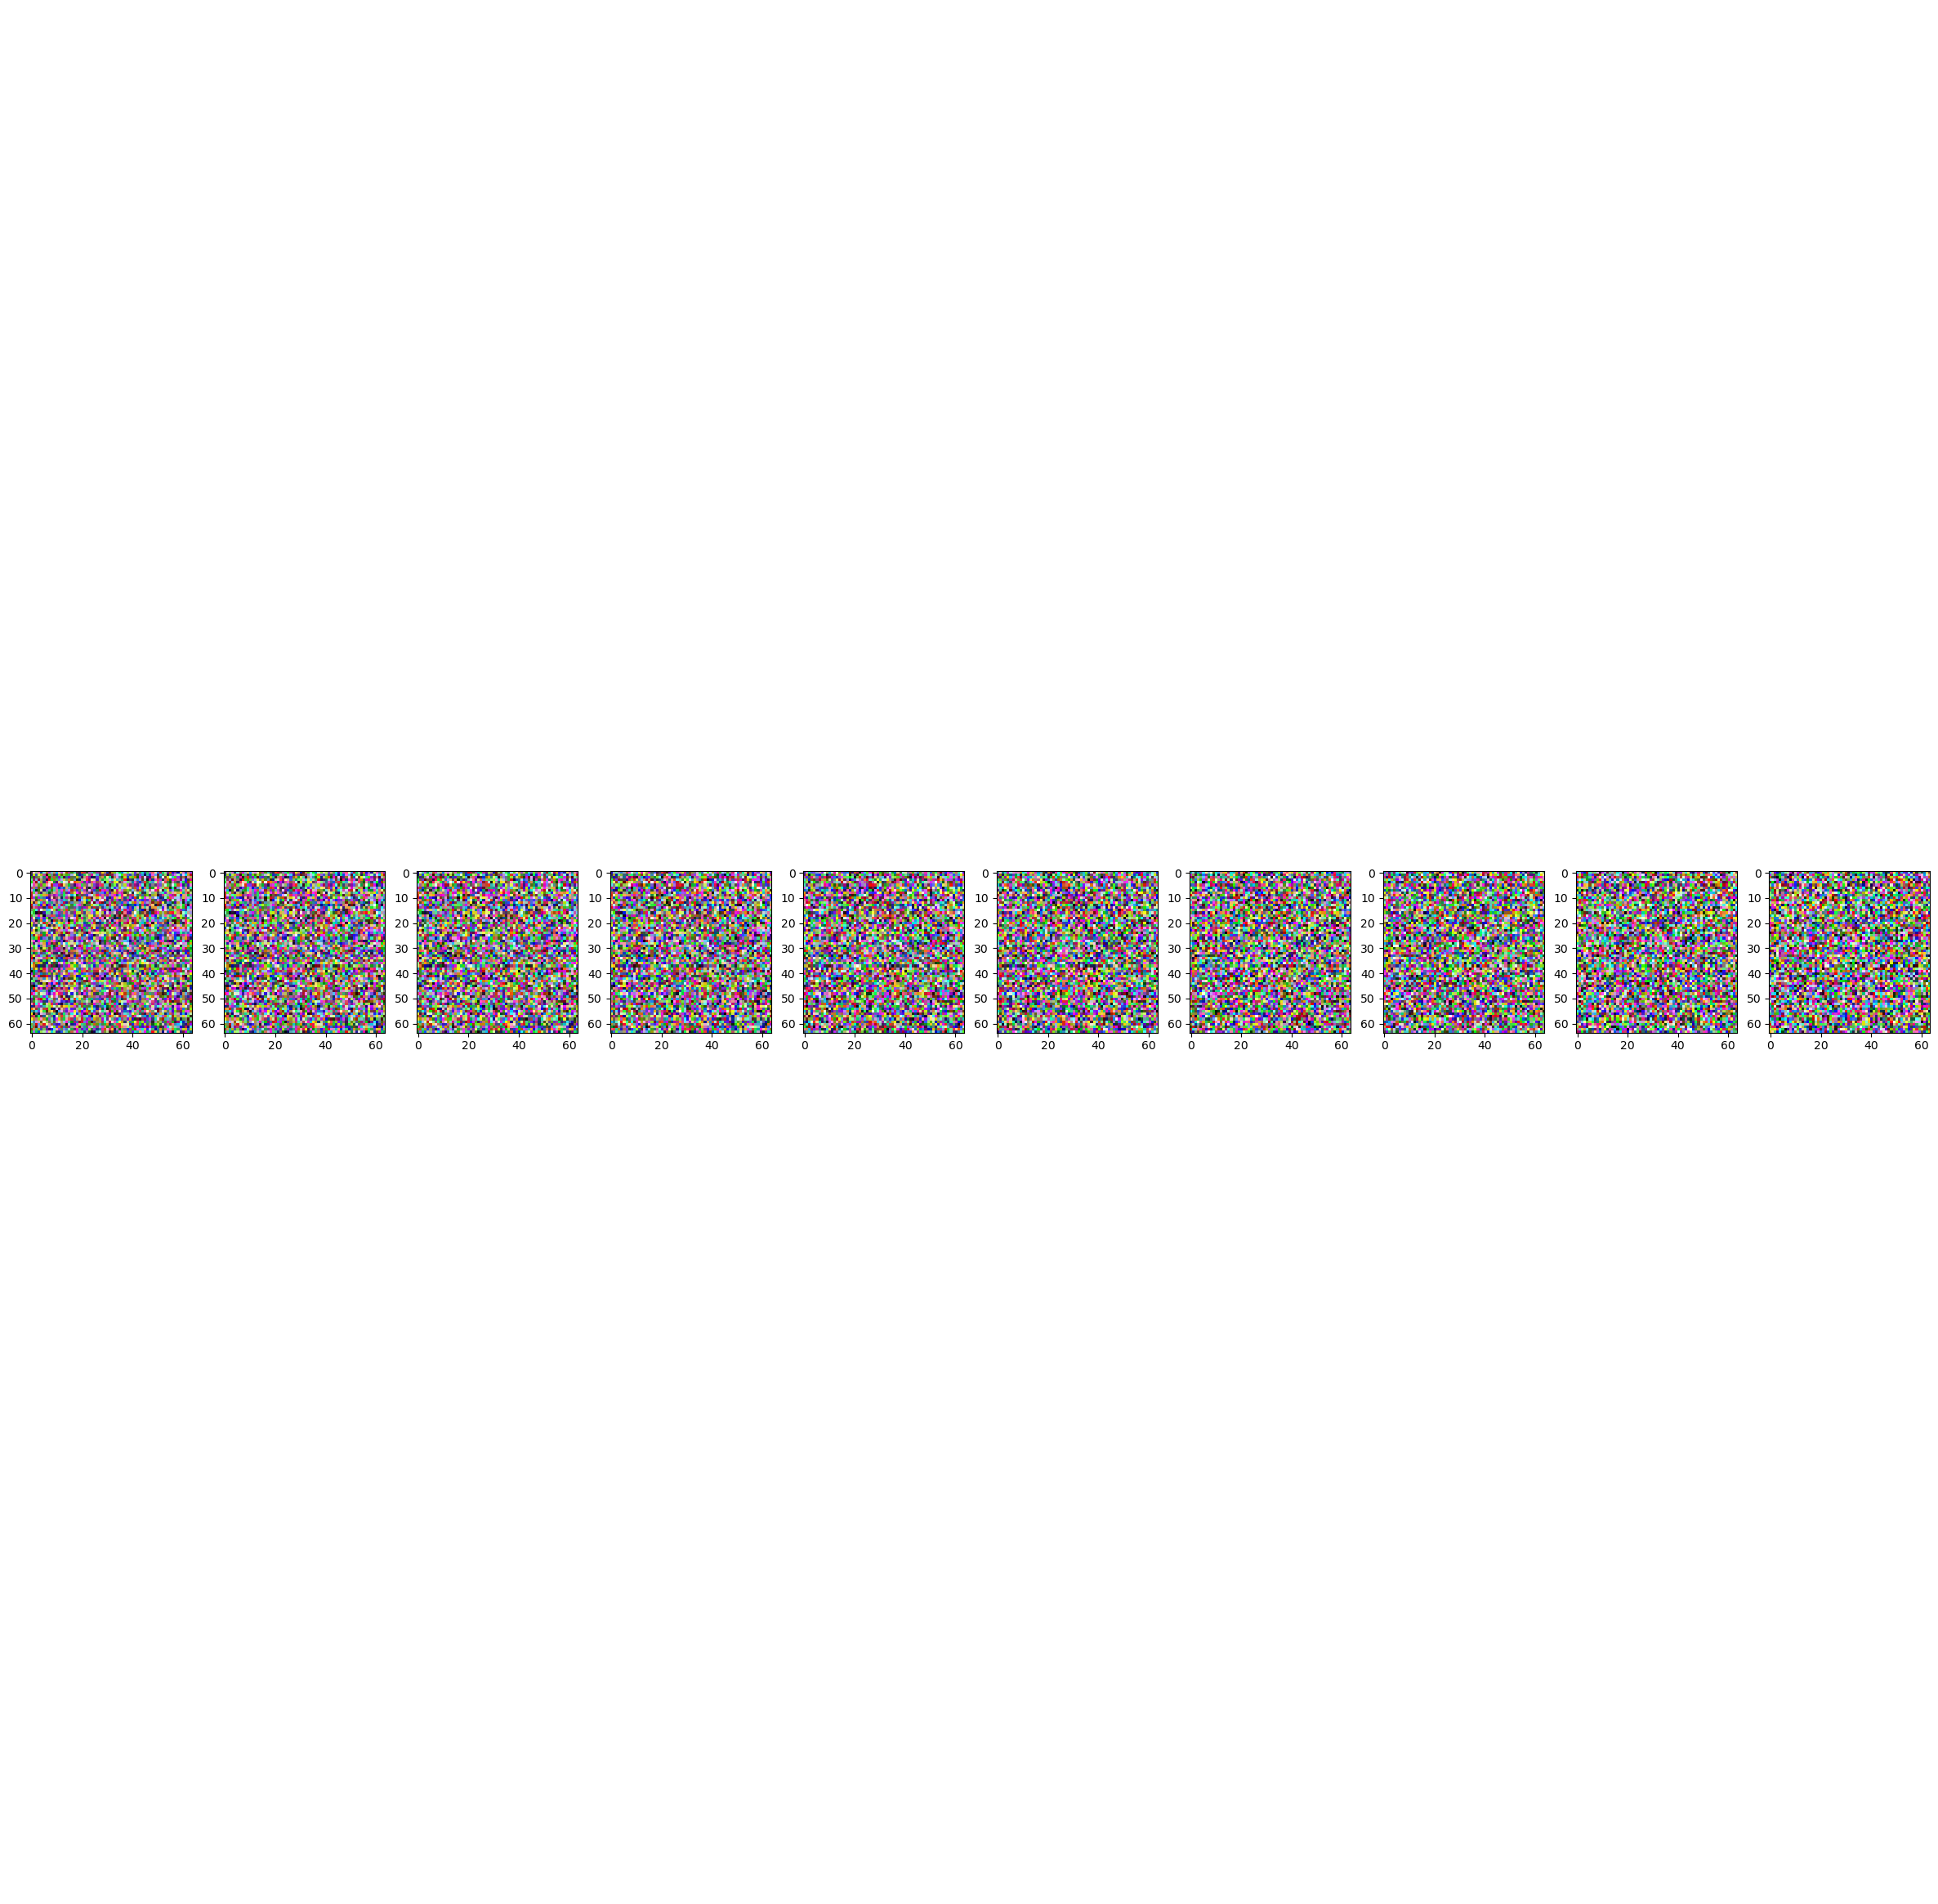

current epoch: 0, step: 1
current epoch: 0, step: 2
current epoch: 0, step: 3
current epoch: 0, step: 4
current epoch: 0, step: 5
current epoch: 0, step: 6
current epoch: 0, step: 7
current epoch: 0, step: 8
current epoch: 0, step: 9
current epoch: 0, step: 10
current epoch: 0, step: 11
current epoch: 0, step: 12
current epoch: 0, step: 13
current epoch: 0, step: 14
current epoch: 0, step: 15
current epoch: 0, step: 16
current epoch: 0, step: 17
current epoch: 0, step: 18
current epoch: 0, step: 19
current epoch: 0, step: 20
current epoch: 0, step: 21
current epoch: 0, step: 22
current epoch: 0, step: 23
current epoch: 0, step: 24
current epoch: 0, step: 25
current epoch: 0, step: 26
current epoch: 0, step: 27
current epoch: 0, step: 28
current epoch: 0, step: 29
current epoch: 0, step: 30
current epoch: 0, step: 31
current epoch: 0, step: 32
current epoch: 0, step: 33
current epoch: 0, step: 34
current epoch: 0, step: 35
current epoch: 0, step: 36
current epoch: 0, step: 37
current ep

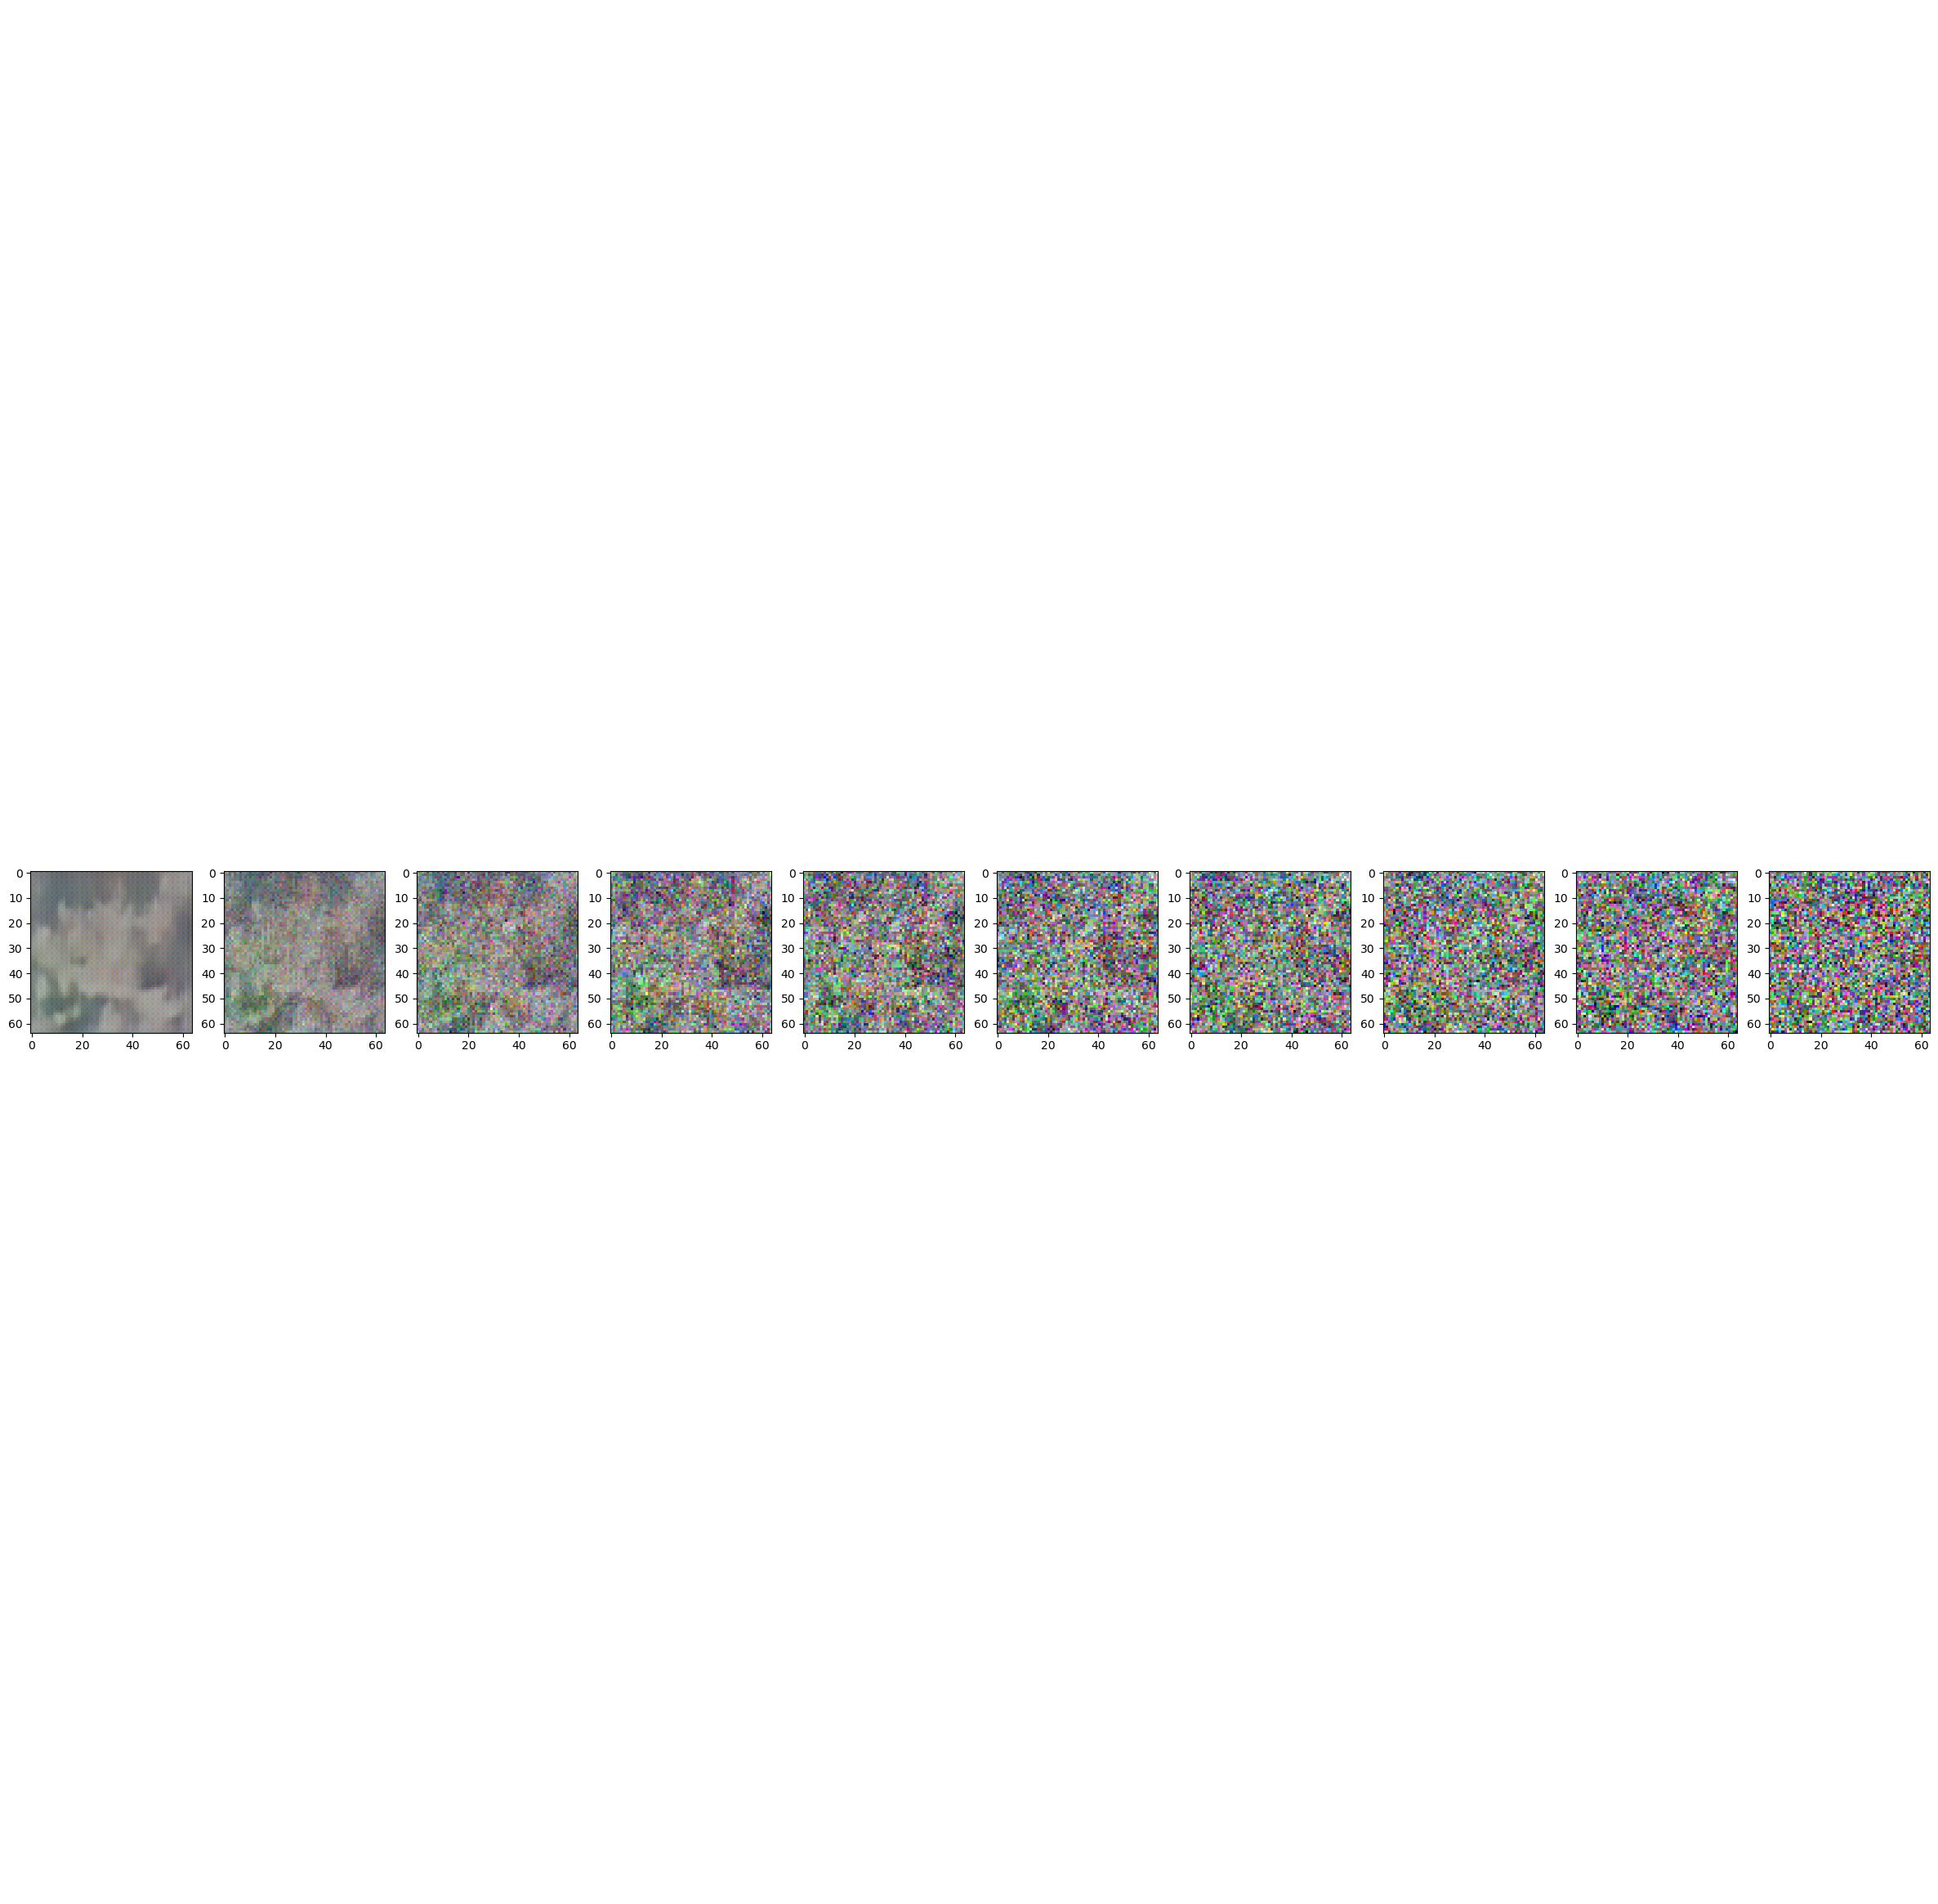

current epoch: 5, step: 1
current epoch: 5, step: 2
current epoch: 5, step: 3
current epoch: 5, step: 4
current epoch: 5, step: 5
current epoch: 5, step: 6
current epoch: 5, step: 7
current epoch: 5, step: 8
current epoch: 5, step: 9
current epoch: 5, step: 10
current epoch: 5, step: 11
current epoch: 5, step: 12
current epoch: 5, step: 13
current epoch: 5, step: 14
current epoch: 5, step: 15
current epoch: 5, step: 16
current epoch: 5, step: 17
current epoch: 5, step: 18
current epoch: 5, step: 19
current epoch: 5, step: 20
current epoch: 5, step: 21
current epoch: 5, step: 22
current epoch: 5, step: 23
current epoch: 5, step: 24
current epoch: 5, step: 25
current epoch: 5, step: 26
current epoch: 5, step: 27
current epoch: 5, step: 28
current epoch: 5, step: 29
current epoch: 5, step: 30
current epoch: 5, step: 31
current epoch: 5, step: 32
current epoch: 5, step: 33
current epoch: 5, step: 34
current epoch: 5, step: 35
current epoch: 5, step: 36
current epoch: 5, step: 37
current ep

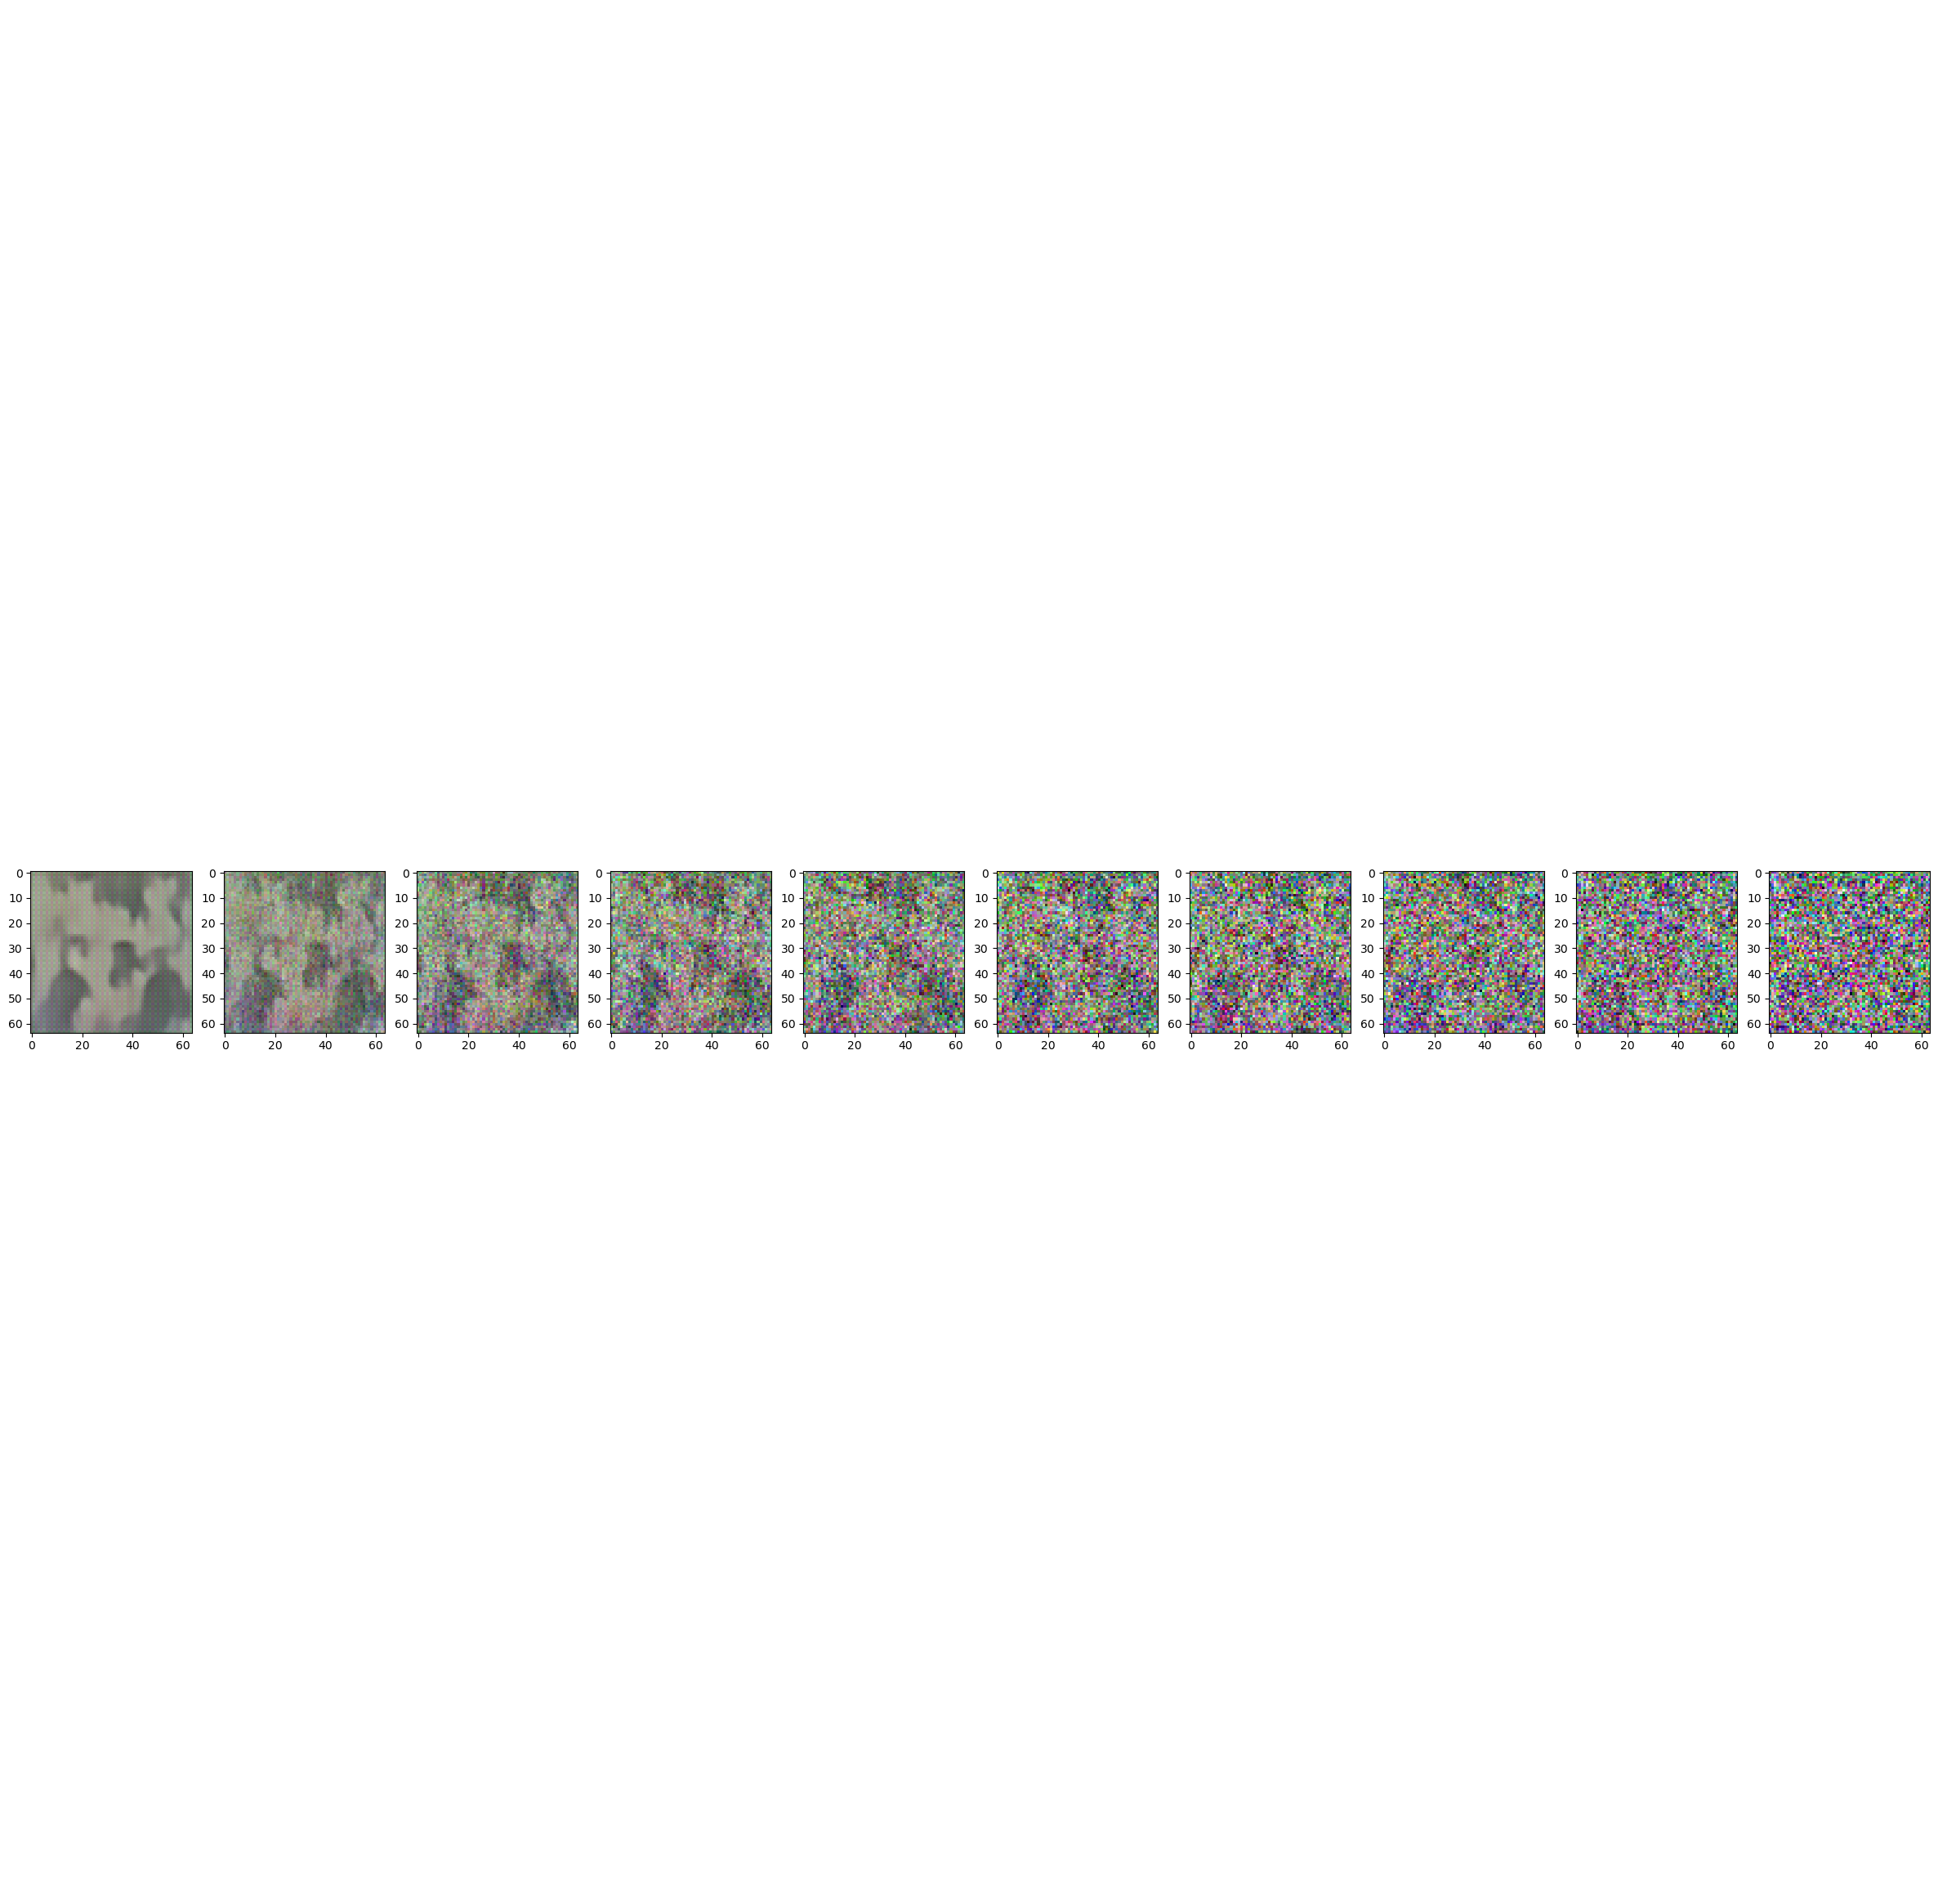

current epoch: 10, step: 1
current epoch: 10, step: 2
current epoch: 10, step: 3
current epoch: 10, step: 4
current epoch: 10, step: 5
current epoch: 10, step: 6
current epoch: 10, step: 7
current epoch: 10, step: 8
current epoch: 10, step: 9
current epoch: 10, step: 10
current epoch: 10, step: 11
current epoch: 10, step: 12
current epoch: 10, step: 13
current epoch: 10, step: 14
current epoch: 10, step: 15
current epoch: 10, step: 16
current epoch: 10, step: 17
current epoch: 10, step: 18
current epoch: 10, step: 19
current epoch: 10, step: 20
current epoch: 10, step: 21
current epoch: 10, step: 22
current epoch: 10, step: 23
current epoch: 10, step: 24
current epoch: 10, step: 25
current epoch: 10, step: 26
current epoch: 10, step: 27
current epoch: 10, step: 28
current epoch: 10, step: 29
current epoch: 10, step: 30
current epoch: 10, step: 31
current epoch: 10, step: 32
current epoch: 10, step: 33
current epoch: 10, step: 34
current epoch: 10, step: 35
current epoch: 10, step: 36
c

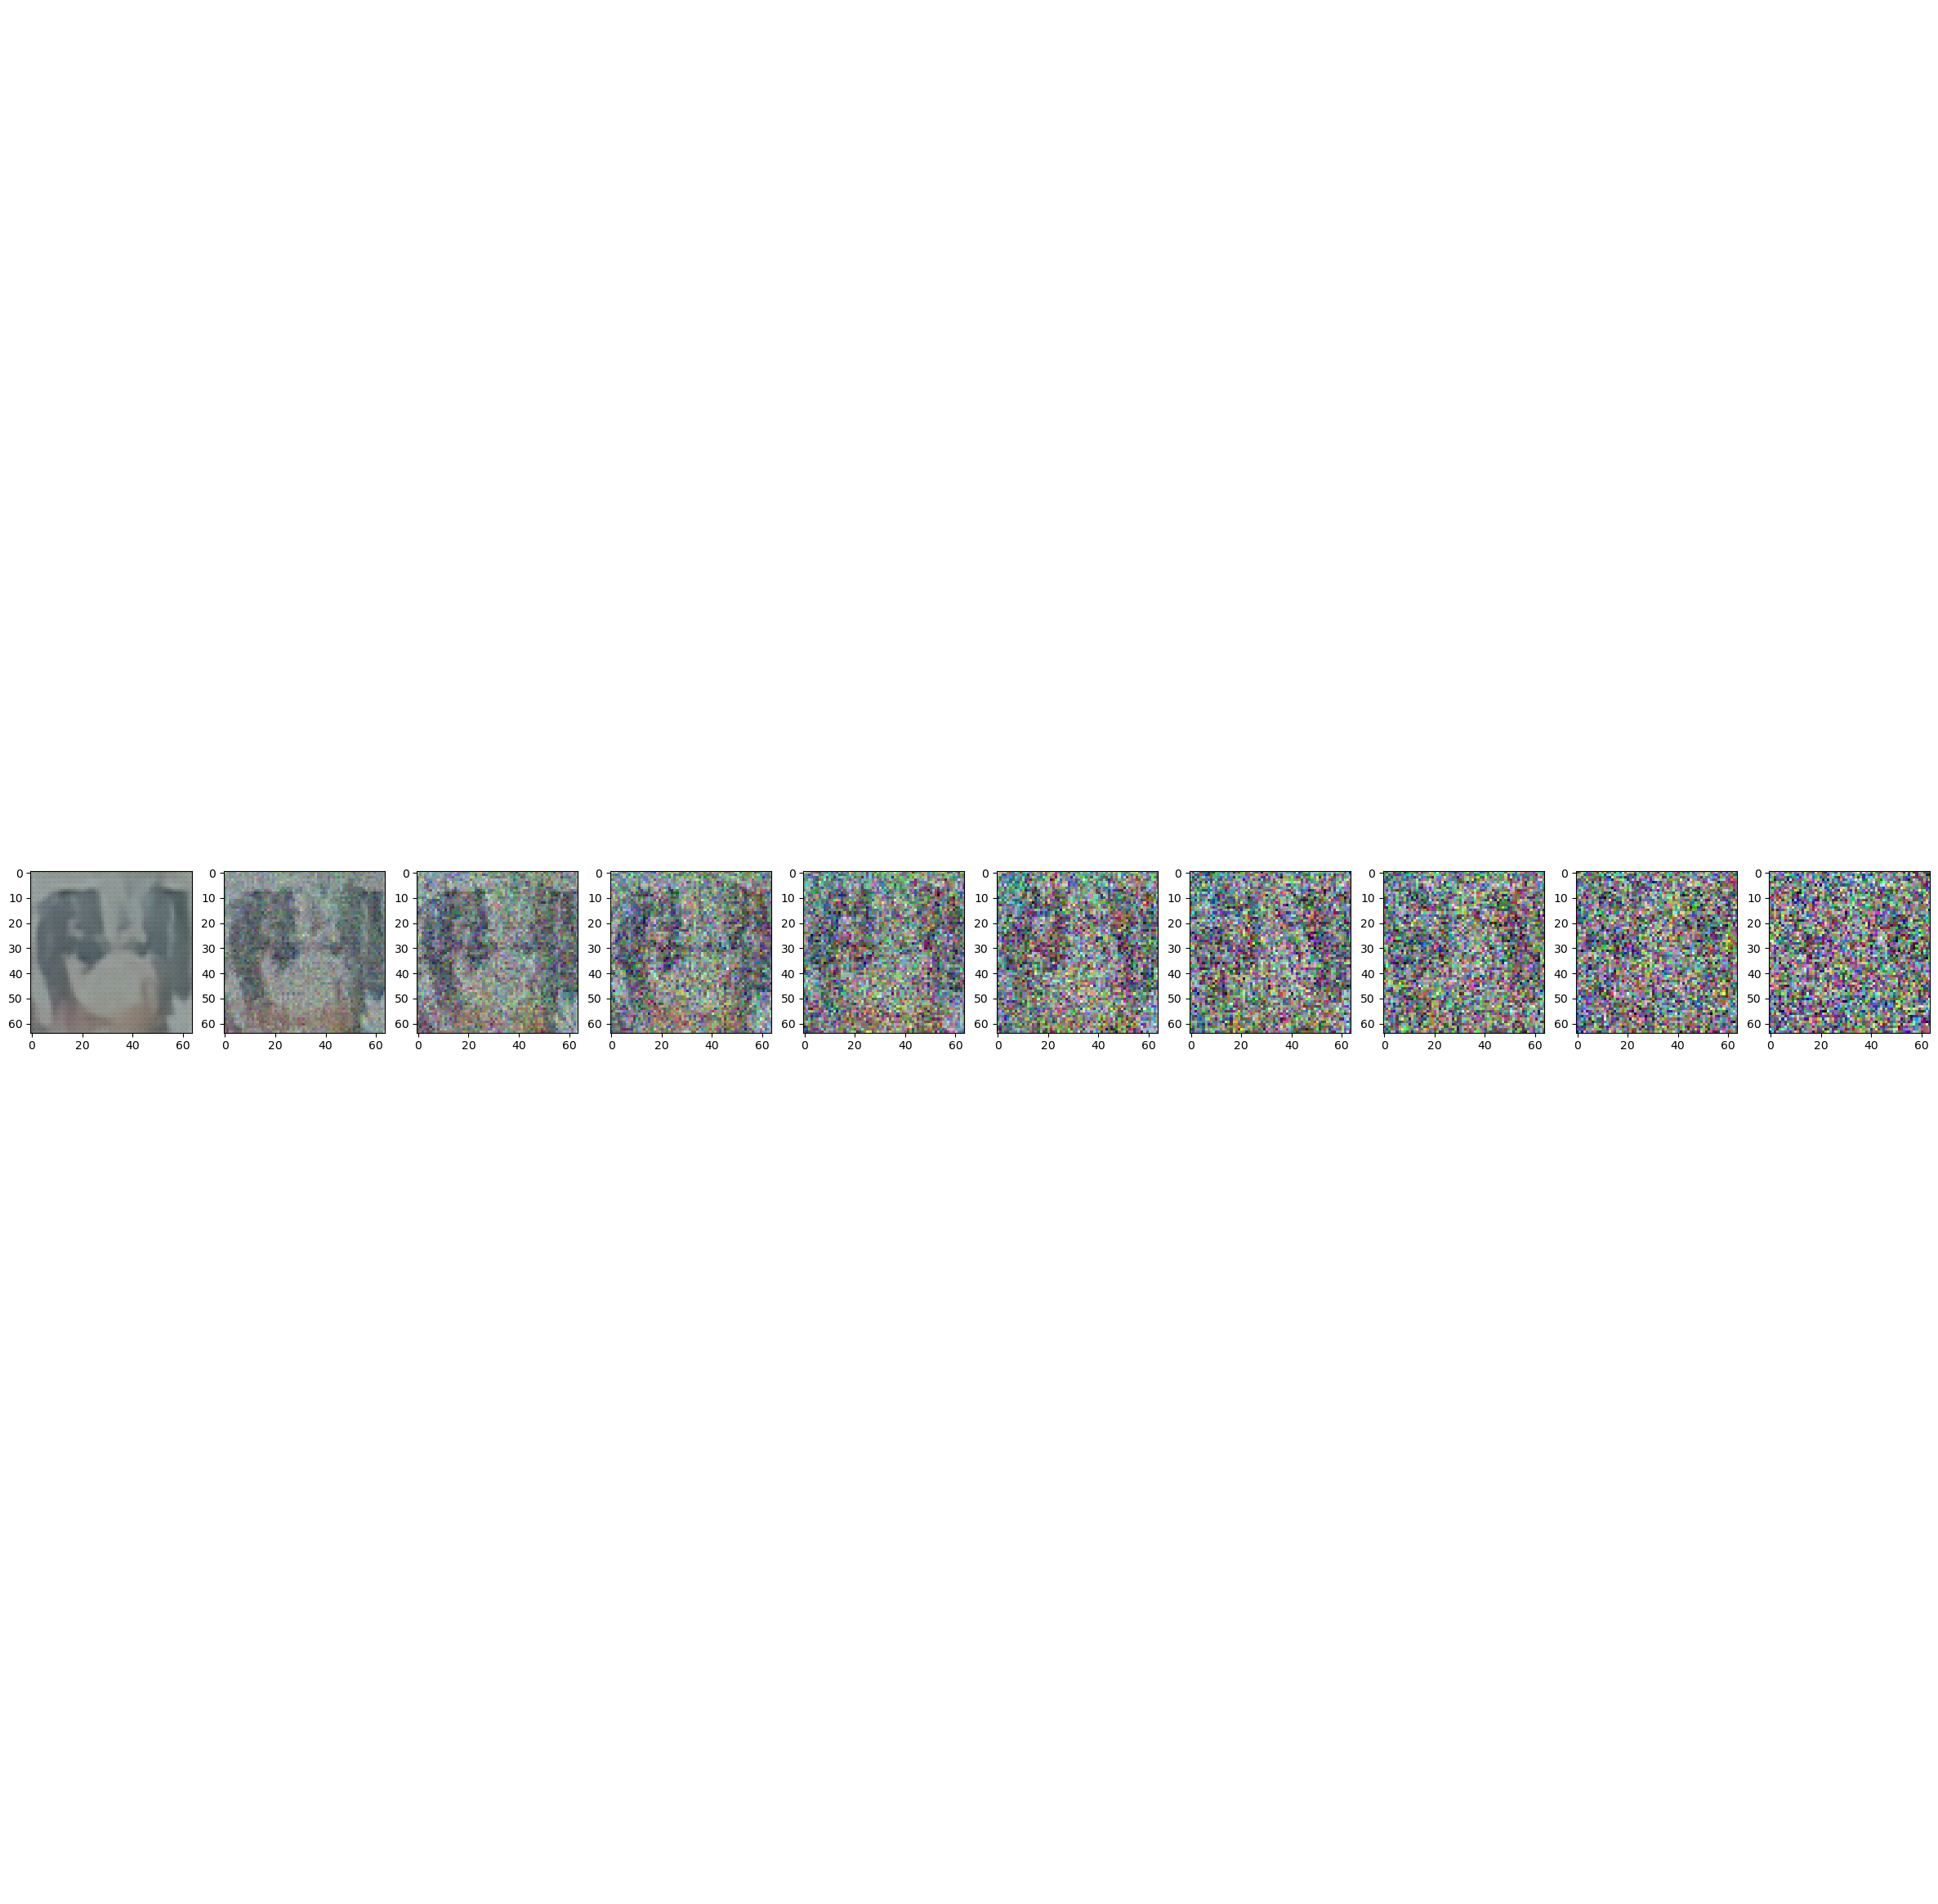

current epoch: 15, step: 1
current epoch: 15, step: 2
current epoch: 15, step: 3
current epoch: 15, step: 4
current epoch: 15, step: 5
current epoch: 15, step: 6
current epoch: 15, step: 7
current epoch: 15, step: 8
current epoch: 15, step: 9
current epoch: 15, step: 10
current epoch: 15, step: 11
current epoch: 15, step: 12
current epoch: 15, step: 13
current epoch: 15, step: 14
current epoch: 15, step: 15
current epoch: 15, step: 16
current epoch: 15, step: 17
current epoch: 15, step: 18
current epoch: 15, step: 19
current epoch: 15, step: 20
current epoch: 15, step: 21
current epoch: 15, step: 22
current epoch: 15, step: 23
current epoch: 15, step: 24
current epoch: 15, step: 25
current epoch: 15, step: 26
current epoch: 15, step: 27
current epoch: 15, step: 28
current epoch: 15, step: 29
current epoch: 15, step: 30
current epoch: 15, step: 31
current epoch: 15, step: 32
current epoch: 15, step: 33
current epoch: 15, step: 34
current epoch: 15, step: 35
current epoch: 15, step: 36
c

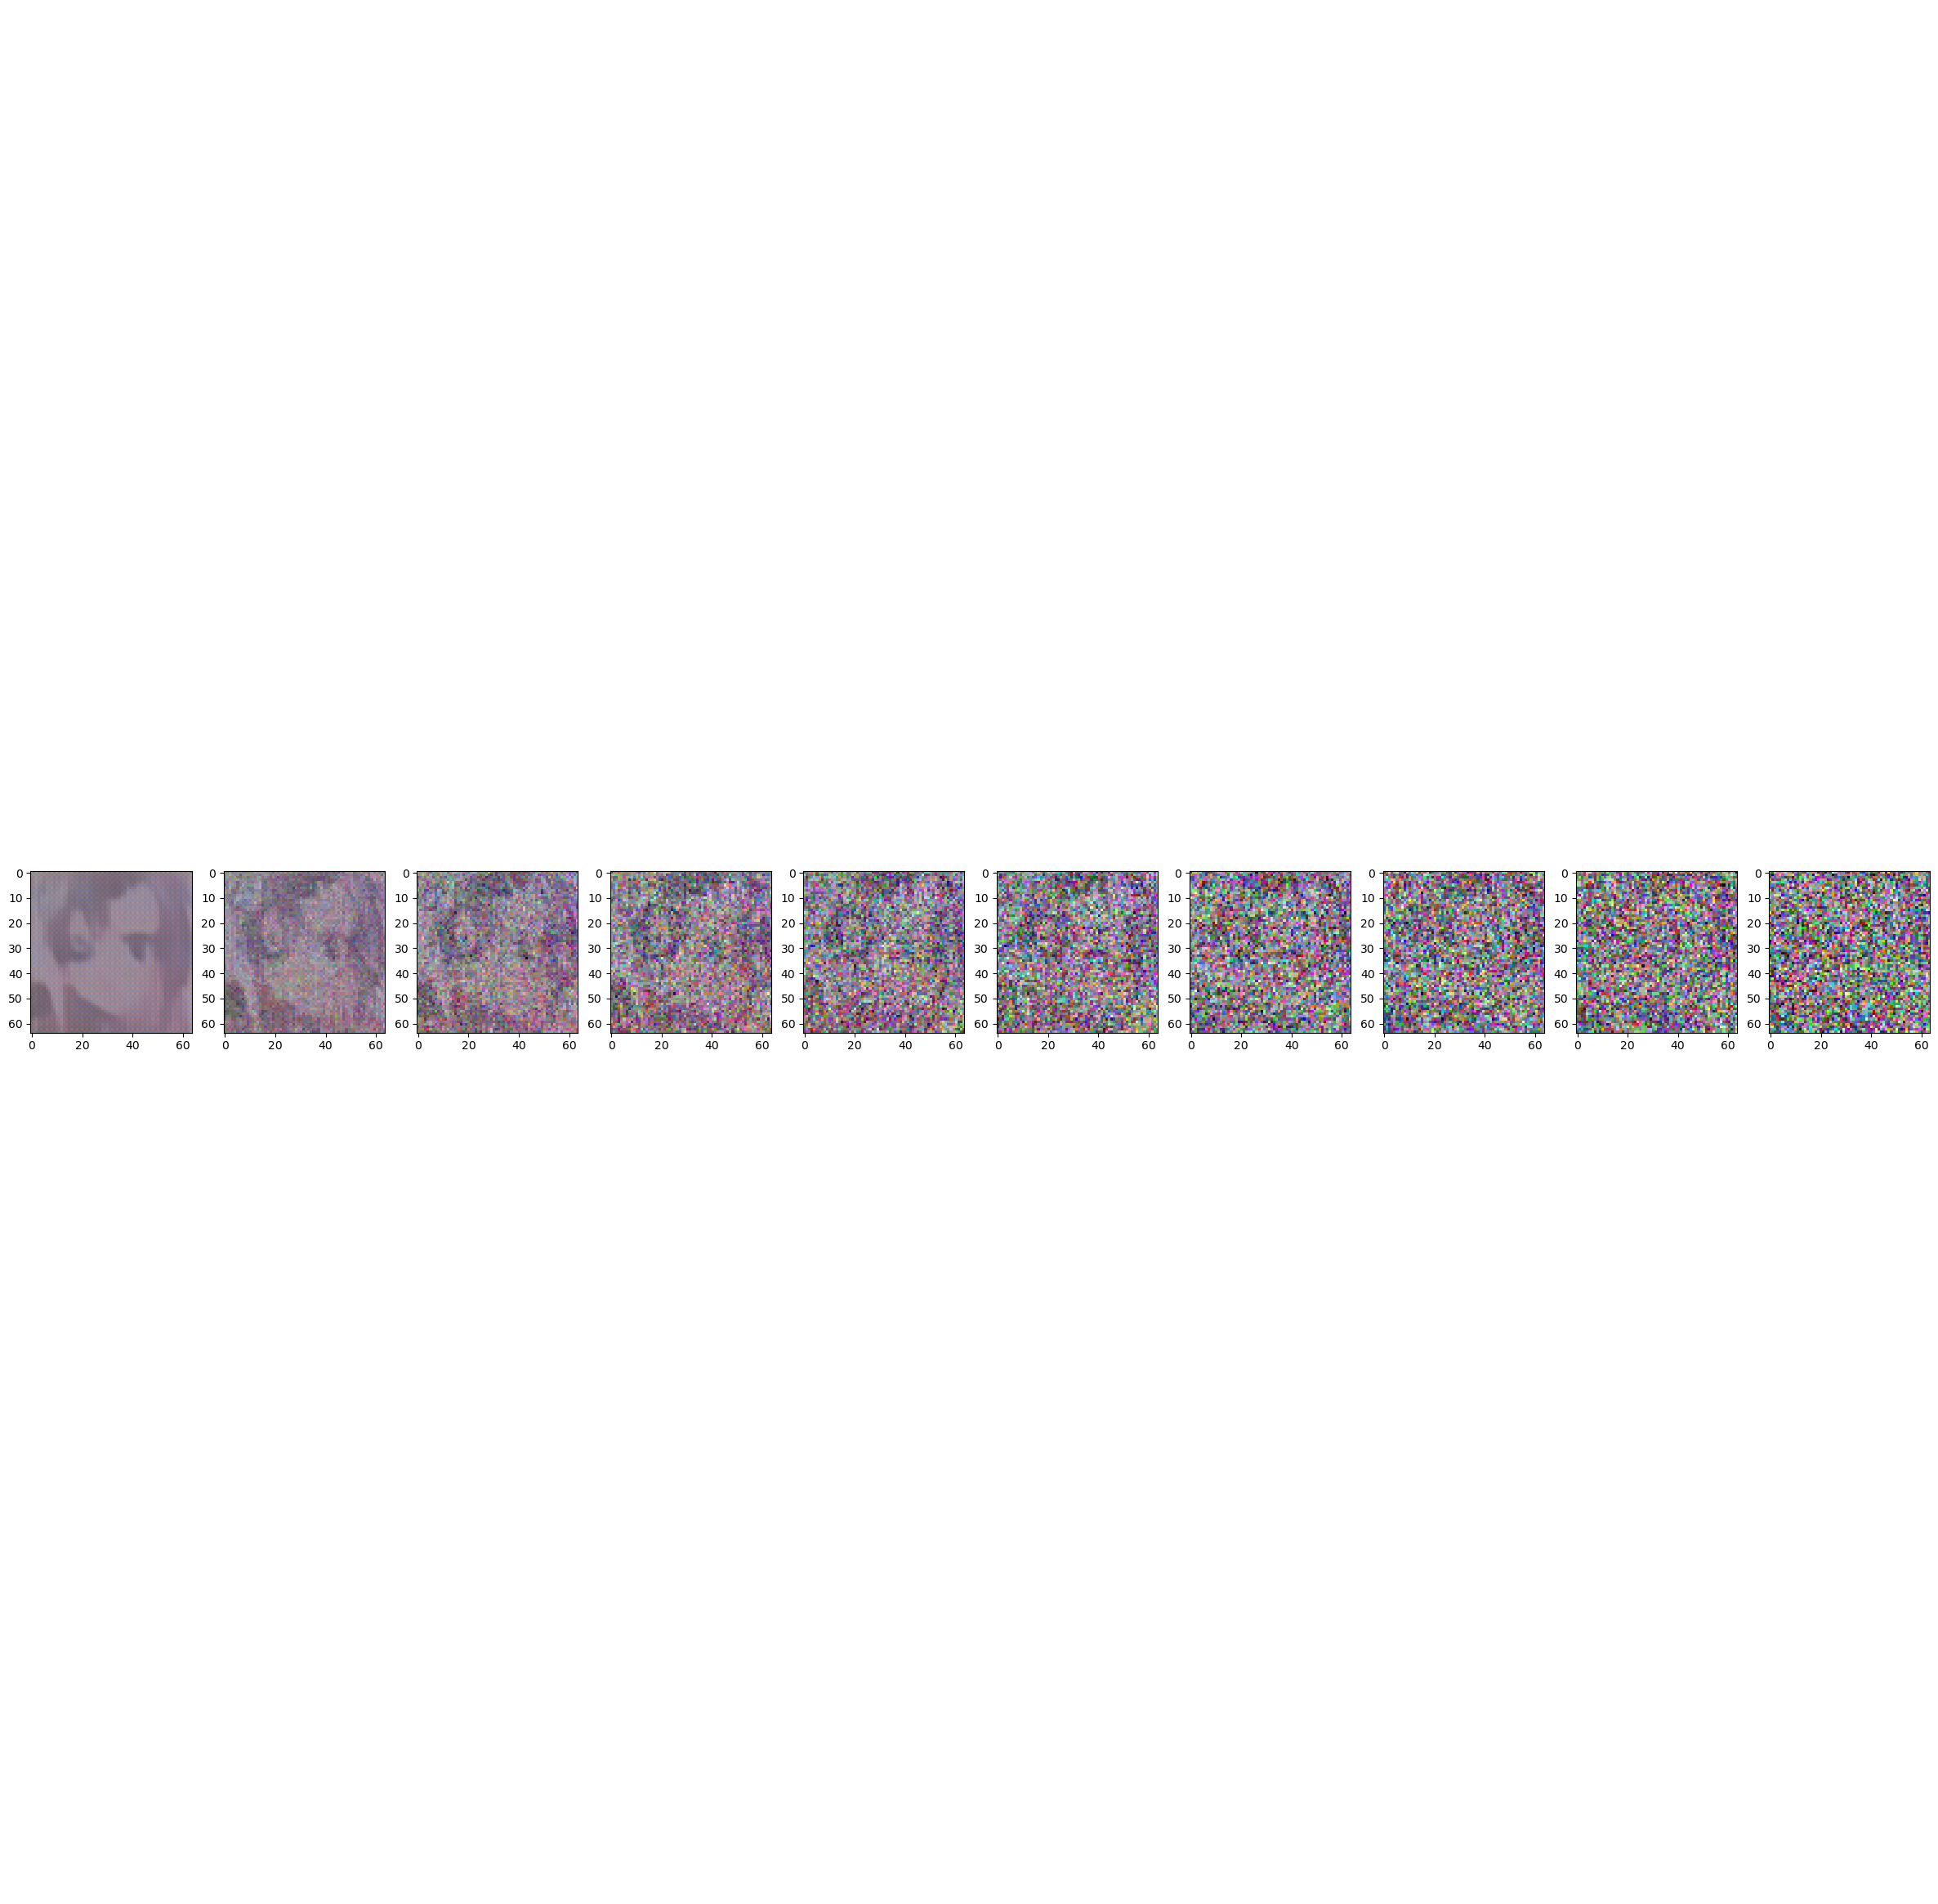

current epoch: 20, step: 1
current epoch: 20, step: 2
current epoch: 20, step: 3
current epoch: 20, step: 4
current epoch: 20, step: 5
current epoch: 20, step: 6
current epoch: 20, step: 7
current epoch: 20, step: 8
current epoch: 20, step: 9
current epoch: 20, step: 10
current epoch: 20, step: 11
current epoch: 20, step: 12
current epoch: 20, step: 13
current epoch: 20, step: 14
current epoch: 20, step: 15
current epoch: 20, step: 16
current epoch: 20, step: 17
current epoch: 20, step: 18
current epoch: 20, step: 19
current epoch: 20, step: 20
current epoch: 20, step: 21
current epoch: 20, step: 22
current epoch: 20, step: 23
current epoch: 20, step: 24
current epoch: 20, step: 25
current epoch: 20, step: 26
current epoch: 20, step: 27
current epoch: 20, step: 28
current epoch: 20, step: 29
current epoch: 20, step: 30
current epoch: 20, step: 31
current epoch: 20, step: 32
current epoch: 20, step: 33
current epoch: 20, step: 34
current epoch: 20, step: 35
current epoch: 20, step: 36
c

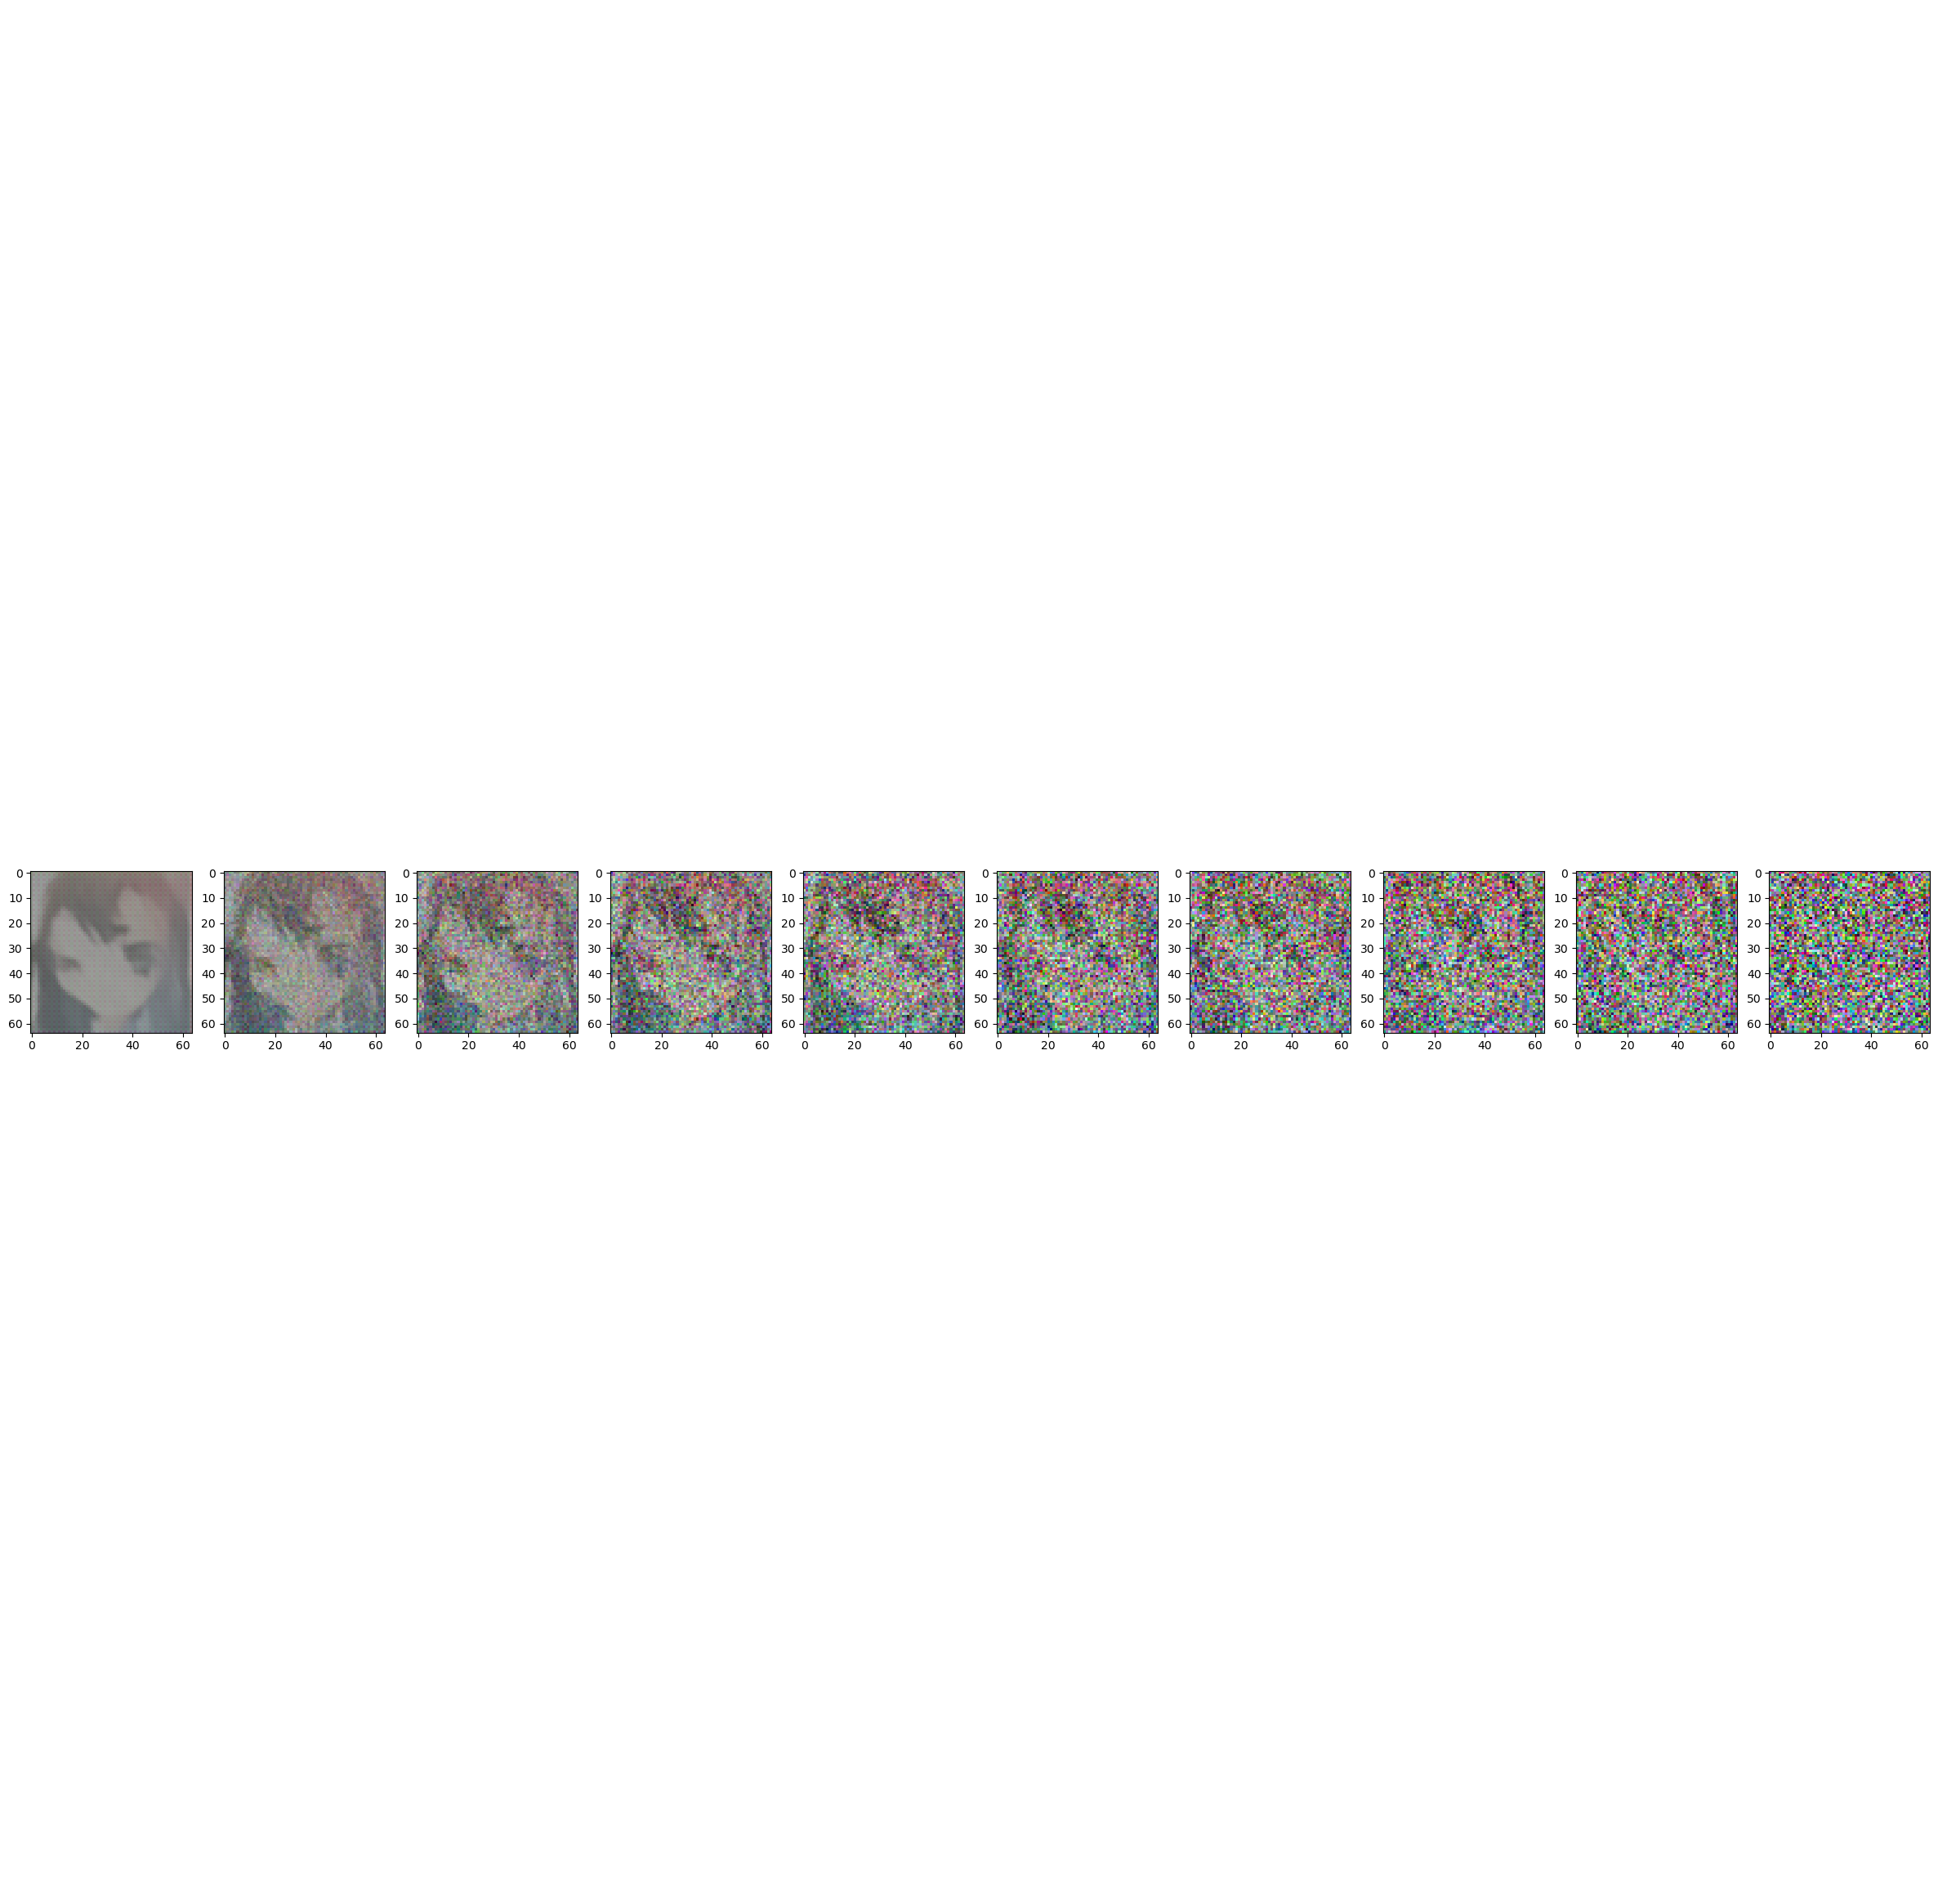

current epoch: 25, step: 1
current epoch: 25, step: 2
current epoch: 25, step: 3
current epoch: 25, step: 4
current epoch: 25, step: 5
current epoch: 25, step: 6
current epoch: 25, step: 7
current epoch: 25, step: 8
current epoch: 25, step: 9
current epoch: 25, step: 10
current epoch: 25, step: 11
current epoch: 25, step: 12
current epoch: 25, step: 13
current epoch: 25, step: 14
current epoch: 25, step: 15
current epoch: 25, step: 16
current epoch: 25, step: 17
current epoch: 25, step: 18
current epoch: 25, step: 19
current epoch: 25, step: 20
current epoch: 25, step: 21
current epoch: 25, step: 22
current epoch: 25, step: 23
current epoch: 25, step: 24
current epoch: 25, step: 25
current epoch: 25, step: 26
current epoch: 25, step: 27
current epoch: 25, step: 28
current epoch: 25, step: 29
current epoch: 25, step: 30
current epoch: 25, step: 31
current epoch: 25, step: 32
current epoch: 25, step: 33
current epoch: 25, step: 34
current epoch: 25, step: 35
current epoch: 25, step: 36
c

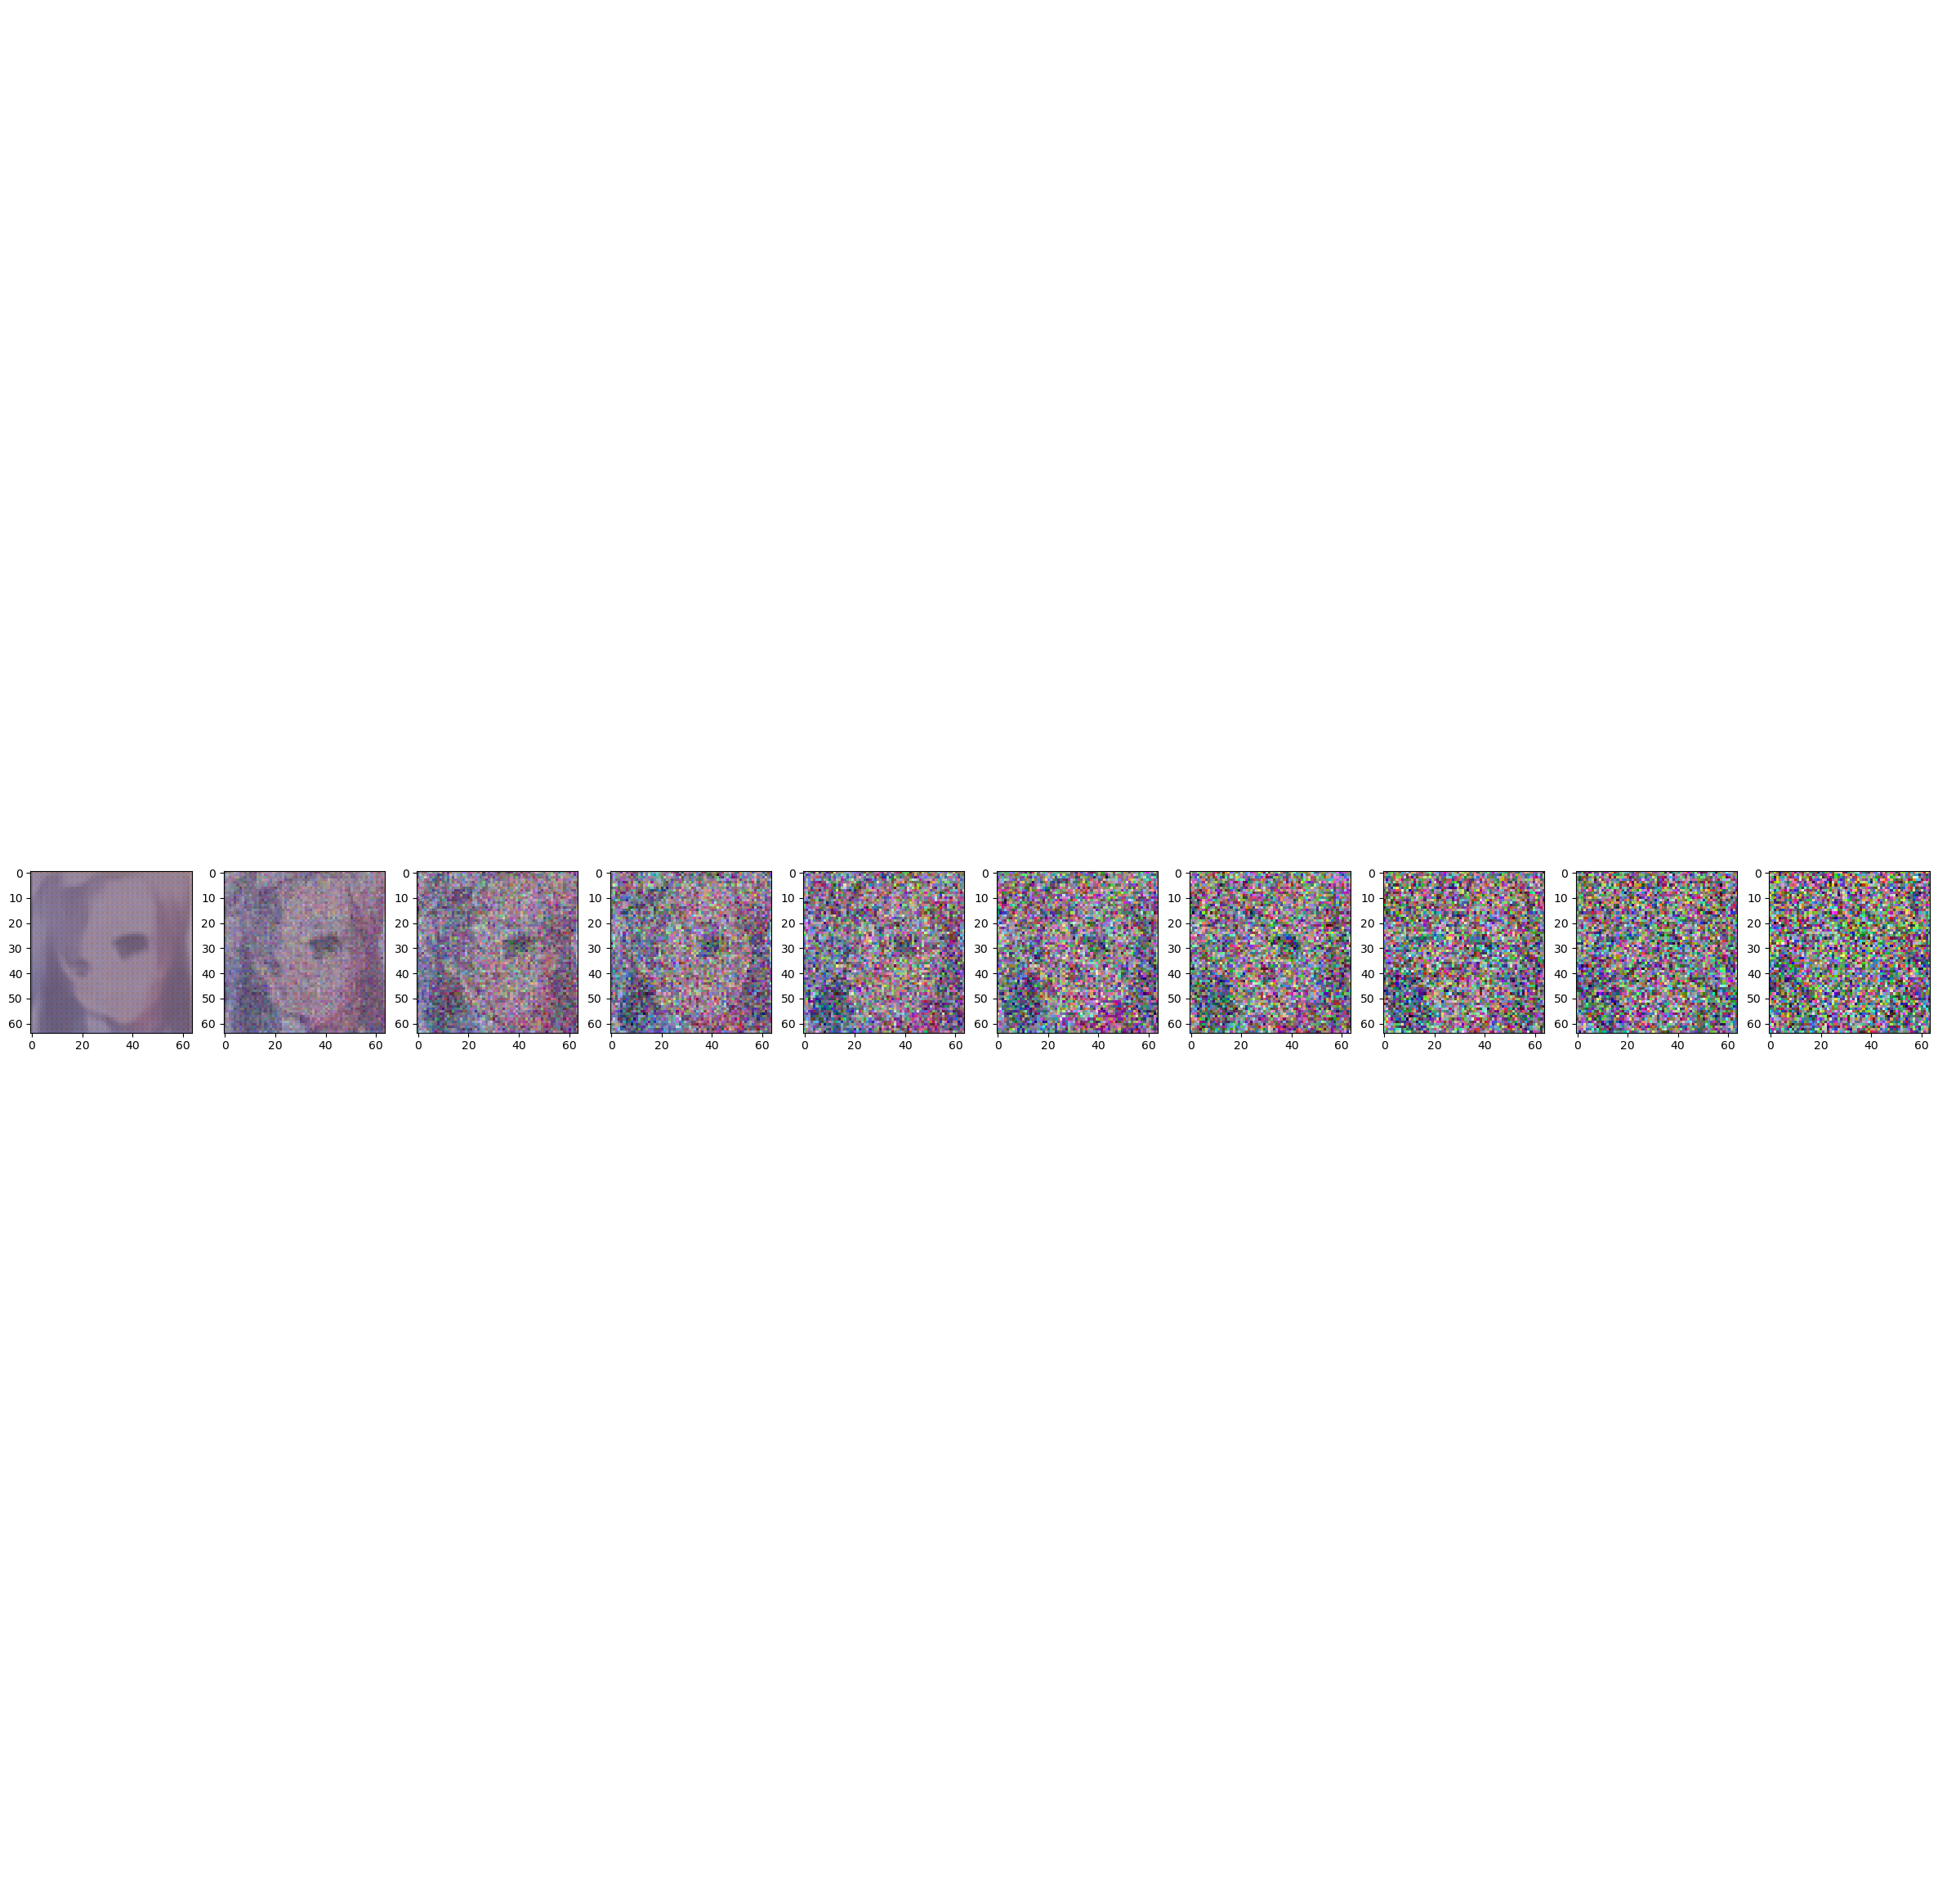

current epoch: 30, step: 1
current epoch: 30, step: 2
current epoch: 30, step: 3
current epoch: 30, step: 4
current epoch: 30, step: 5
current epoch: 30, step: 6
current epoch: 30, step: 7
current epoch: 30, step: 8
current epoch: 30, step: 9
current epoch: 30, step: 10
current epoch: 30, step: 11
current epoch: 30, step: 12
current epoch: 30, step: 13
current epoch: 30, step: 14
current epoch: 30, step: 15
current epoch: 30, step: 16
current epoch: 30, step: 17
current epoch: 30, step: 18
current epoch: 30, step: 19
current epoch: 30, step: 20
current epoch: 30, step: 21
current epoch: 30, step: 22
current epoch: 30, step: 23
current epoch: 30, step: 24
current epoch: 30, step: 25
current epoch: 30, step: 26
current epoch: 30, step: 27
current epoch: 30, step: 28
current epoch: 30, step: 29
current epoch: 30, step: 30
current epoch: 30, step: 31
current epoch: 30, step: 32
current epoch: 30, step: 33
current epoch: 30, step: 34
current epoch: 30, step: 35
current epoch: 30, step: 36
c

In [7]:
from torch.optim import Adam

device = torch.device('mps')
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 150


for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        print(f'current epoch: {epoch}, step: {step}')
        # Debugged 最后我意识到只需要在产生t的时候把x和t对齐就好了...
        t = torch.randint(0, T, (batch[0].shape[0],), device=device).long()
        optimizer.zero_grad()
        # batch的处理这里也有个坑啊！enumerate出来的batch是一个二个元素的列表，第一个维度才是我们要的batch，它的第二个维度是labbel！但是我们是autoregressive的model，所以根本用不上这个（
        loss = get_diffusion_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f'epoch: {epoch:03d} step: {step:03d} Loss: {loss.item()} ')
            sample_plot_img(model, T) # 测试我们的model

model_path = './model_prelu_br.pth'
torch.save(model.state_dict(), model_path)
print(f'model saved to {model_path}')

测试模型，感觉100个epoch完全不行啊...要不学习率调大点

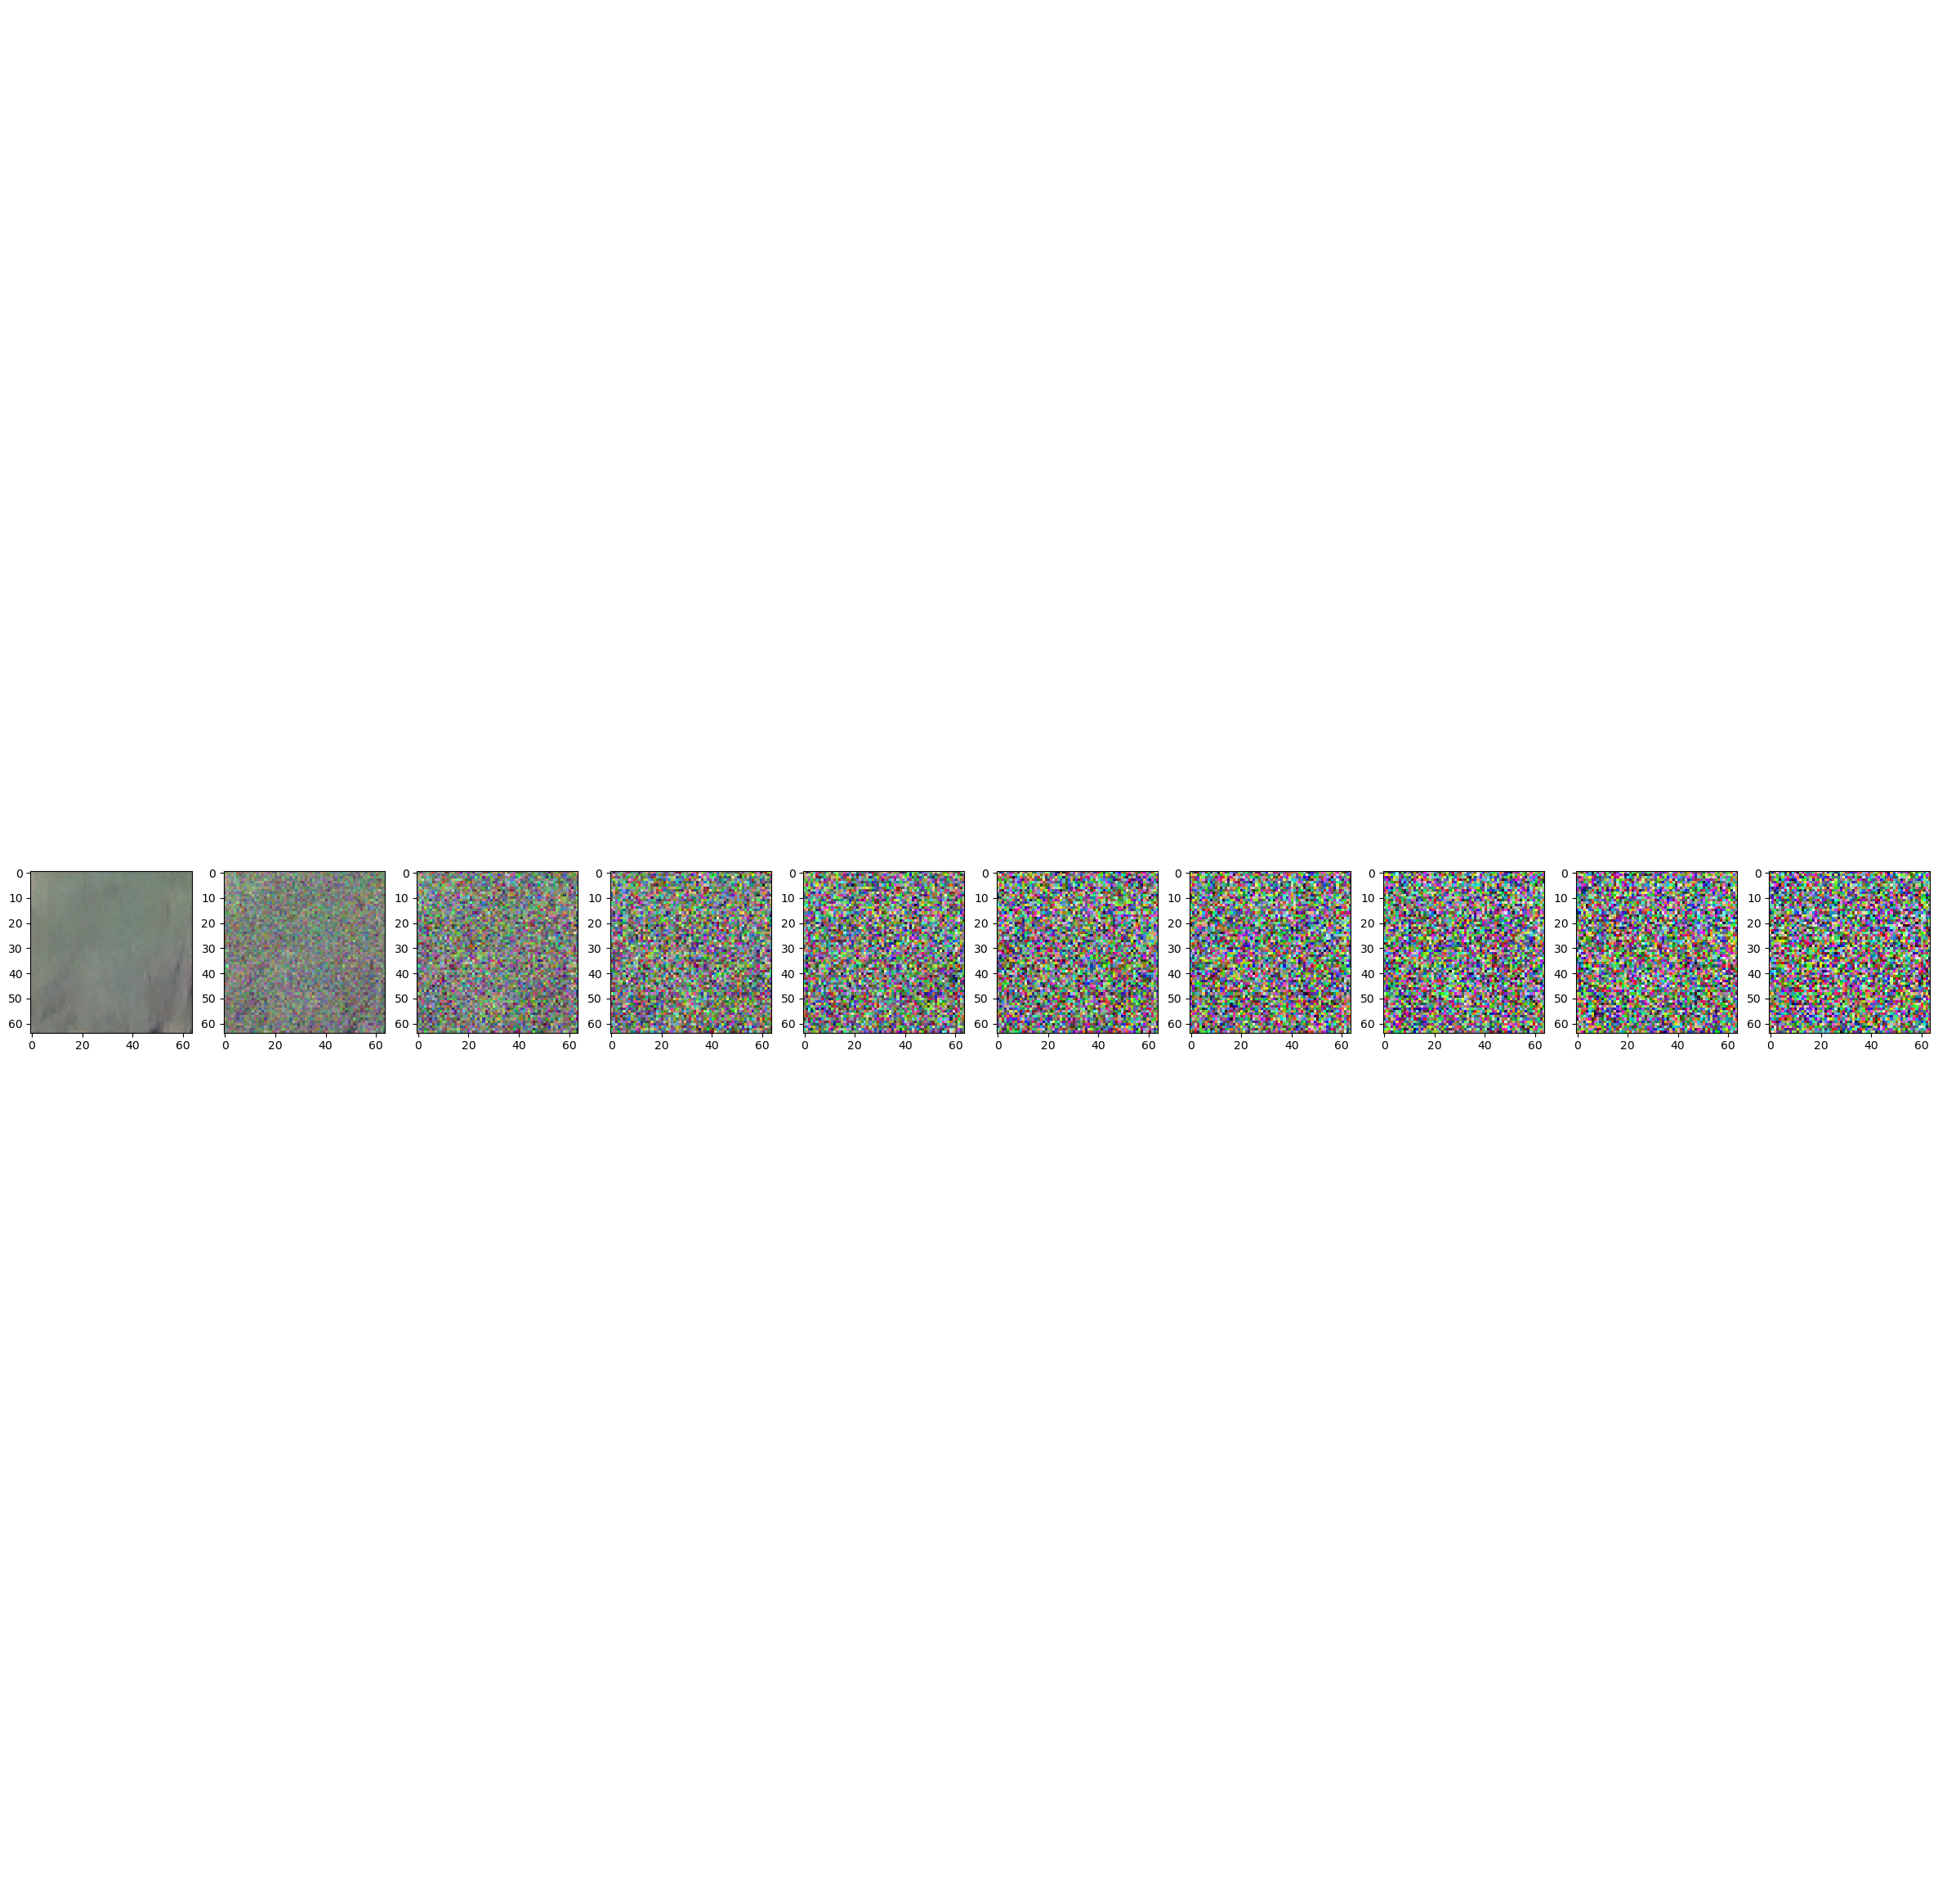

In [ ]:
model = SimpleUnet()
model.load_state_dict(torch.load('./model.pth', map_location=device))
model.to(device)
model.eval()

sample_plot_img(model=model,T=300)